In [1]:
#hide
! [ -e /content ] && pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

#### 

In [2]:
#hide
from fastai.vision.all import *
from fastbook import *

matplotlib.rc('image', cmap='Greys')

# Under the Hood: Training a Digit Classifier

Having seen what it looks like to actually train a variety of models in Chapter 2, **let’s now look under the hood and see exactly what is going on**.  
We’ll start by **using computer vision** to introduce fundamental tools and concepts for deep learning.

To be exact, we'll discuss the **roles of arrays and tensors and of broadcasting**, a powerful technique for using them expressively.  
We'll explain **stochastic gradient descent (SGD)**, the mechanism for learning by updating weights automatically.  
We'll discuss the choice of a **loss function** for our basic classification task, and the role of mini-batches.  
We'll also describe **the math that a basic neural network** is actually doing.  
Finally, we'll put all these pieces together.

In future chapters we’ll do deep dives into other applications as well, and see how these concepts and tools generalize.  
But this chapter is about **laying foundation stones**. To be frank, that also makes this one of the hardest chapters, because of how these concepts all depend on each other.  
Like an arch, all the stones need to be in place for the structure to stay up. Also like an arch, once that happens, it's a powerful structure that can support other things.  
But it requires some patience to assemble.

Let's begin. The first step is to consider how images are represented in a computer.

## Pixels: The Foundations of Computer Vision

In order to understand what happens in a **computer vision model**, we first have to understand **how computers handle images**.  
We'll use one of **the most famous datasets in computer vision, [MNIST](https://en.wikipedia.org/wiki/MNIST_database)**, for our experiments.  
MNIST contains images of handwritten digits, collected by the National Institute of Standards and Technology and collated into a machine learning dataset by Yann Lecun and his colleagues.  
Lecun used MNIST in 1998 in [Lenet-5](http://yann.lecun.com/exdb/lenet/), the first computer system to demonstrate practically useful recognition of handwritten digit sequences.  
This was one of the most important breakthroughs in the history of AI.

## Sidebar: Tenacity and Deep Learning

The story of deep learning is one of tenacity and grit by a handful of dedicated researchers.  
After early hopes (and hype!) neural networks went out of favor in the 1990's and 2000's, and just a handful of researchers kept trying to make them work well.  
Three of them, Yann Lecun, Yoshua Bengio, and Geoffrey Hinton, were awarded the highest honor in computer science, the Turing Award (generally considered the "Nobel Prize of computer science"),  
in 2018 after triumphing despite the deep skepticism and disinterest of the wider machine learning and statistics community.

Geoff Hinton has told of how even academic papers showing dramatically better results than anything previously published would be rejected by top journals and conferences, just because they used a neural network.  
Yann Lecun's work on convolutional neural networks, which we will study in the next section, showed that these models could read handwritten text—something that had never been achieved before.  
However, his breakthrough was ignored by most researchers, even as it was used commercially to read 10% of the checks in the US!

In addition to these three Turing Award winners, there are many other researchers who have battled to get us to where we are today.  
For instance, Jurgen Schmidhuber (who many believe should have shared in the Turing Award) pioneered many important ideas, 
including working with his student Sepp Hochreiter on the long short-term memory (LSTM) architecture (widely used for speech recognition and other text modeling tasks, and used in the IMDb example in <<chapter_intro>>).  
Perhaps most important of all, Paul Werbos in 1974 invented back-propagation for neural networks, the technique shown in this chapter and used universally for training neural networks ([Werbos 1994](https://books.google.com/books/about/The_Roots_of_Backpropagation.html?id=WdR3OOM2gBwC)).  
His development was almost entirely ignored for decades, but today it is considered the most important foundation of modern AI.

There is a lesson here for all of us! On your deep learning journey you will face many obstacles, both technical, and (even more difficult) posed by people around you who don't believe you'll be successful.  
There's one *guaranteed* way to fail, and that's to stop trying.  
We've seen that the only consistent trait amongst every fast.ai student that's gone on to be a world-class practitioner is that they are all very tenacious.

## End sidebar

For this initial tutorial we are just going to try to **create a model that can classify any image as a 3 or a 7**.  
So let's download a **sample of MNIST that contains images of just these digits:**

In [10]:
URLs.MNIST_SAMPLE

'https://s3.amazonaws.com/fast-ai-sample/mnist_sample.tgz'

In [11]:
# https://docs.fast.ai/data.external.html  - downloads them to /home/.fastai folder
path = untar_data(URLs.MNIST_SAMPLE)

In [12]:
#hide
Path.BASE_PATH = path

In [13]:
path  # tells me where it is; path is . because I used this special base_path attribute to path, to tell it where's my starting point

Path('.')

In [14]:
type(path)  # it's a pathlib path object; pathlib is part of the python standard library; p s l doesn't have ls though, so we addded ls 

pathlib.PosixPath

In [15]:
#path.ls?  # from where it comes from: a library called fastcore, which is a lot of the foundational stuff in fastai that is not dependent on pytorch, pandas or any of these big libraries

In [16]:
#path.ls??  # if you want to see exactly what it does put ?? to get the source code

In [17]:
doc(path.ls)  # documentation, to see examples, pictures, tutorials, tests

We can see **what's in this directory by using `ls`**, a method added by fastai.  
This method returns an object of a special fastai class called `L`, which has all the same functionality of Python's built-in `list`, plus a lot more.  
One of its handy features is that, when printed, it displays **the count of items**, before **listing the items** themselves (if there are more than 10 items, it just shows the first few):

In [18]:
path.ls()  # it makes it easier not to have to see the whole set of parent path folders; use ls to see what's in the dataset 
           # there's a train folder and valid folder

(#3) [Path('train'),Path('valid'),Path('labels.csv')]

The MNIST dataset follows a common layout for machine learning datasets: **separate folders for the training set and the validation set (and/or test set)**.  
Let's see what's **inside the training set:**

In [19]:
(path/'train').ls()  # this looks like our bear classifier data set; we downloaded each set of images into a folder based on what its label was (3 or 7)

(#2) [Path('train/7'),Path('train/3')]

There's a folder of 3s, and a folder of 7s. In machine learning parlance, we say that **"3" and "7" are the *labels* (or targets)** in this dataset.  
Let's take a look in one of these folders (using **`sorted`** to ensure we all get the same order of files):

In [20]:
threes = (path/'train'/'3').ls().sorted()  # they's just numbered 
sevens = (path/'train'/'7').ls().sorted()
threes

(#6131) [Path('train/3/10.png'),Path('train/3/10000.png'),Path('train/3/10011.png'),Path('train/3/10031.png'),Path('train/3/10034.png'),Path('train/3/10042.png'),Path('train/3/10052.png'),Path('train/3/1007.png'),Path('train/3/10074.png'),Path('train/3/10091.png')...]

As we might expect, it's full of image files.  
Let’s take a look at one now.  
Here’s an image of a **handwritten number 3**, taken from the famous MNIST dataset of handwritten numbers:

In [21]:
im3_path = threes[1]        
im3 = Image.open(im3_path)
im3

In [22]:
type(im3)  # PIL is python imaging library (the most popular lib by far for working with images and its a PNG); PIL will come with something that displays the image

PIL.PngImagePlugin.PngImageFile

Here we are using the **`Image` class from the *Python Imaging Library* (PIL)**, which is the most widely used Python package for opening, manipulating, and viewing images.  
Jupyter knows about PIL images, so it displays the image for us automatically.

In a computer, everything is represented as a number.  
**To view the numbers that make up this image, we have to convert it to a *NumPy array* or a *PyTorch tensor***.  
For instance, here's what a section of the image looks like, converted to a **NumPy array**:

In [23]:
'''
one easy way to treat things as numbers is to turn them into an array
the array is part of numpy, the most popular array programming library for python
so if we pass our PIL image object to array it just converts the image into a bunch of numbers
the truth is it was a bunch of numbers the whole time
it was stored as bunch of numbers on disk
it just that there's this magic thing in jupyter that knows how to display those numbers on the screen
an image is just a bunch of numbers on a pc, so we can compute with it
'''
array(im3)[4:10,4:10]  # this converts the image im3 to numbers in form of an array

array([[  0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,  29],
       [  0,   0,   0,  48, 166, 224],
       [  0,  93, 244, 249, 253, 187],
       [  0, 107, 253, 253, 230,  48],
       [  0,   3,  20,  20,  15,   0]], dtype=uint8)

**The `4:10` indicates we requested the rows from index 4 (included) to 10 (not included) and the same for the columns**.  
NumPy indexes from top to bottom and left to right, so this section is located in the top-left corner of the image.  
Here's the same thing as a **PyTorch tensor**:

In [24]:
'''
a tensor is the pytorch version of a numpy array
a pytorch tensor and numpy array behave nearly identically, much if not most of the time
the key thing is a pytorch tensor can also be computed on a gpu, not just cpu
so we use tensors because they have all the benefits of numpy arrays plus all the benefits of gpu computation
and they have a whole lot of extra functionality as well
'''
tensor(im3)[4:10,4:10]  # this converts the image im3 to numbers in form of an tensor

tensor([[  0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,  29],
        [  0,   0,   0,  48, 166, 224],
        [  0,  93, 244, 249, 253, 187],
        [  0, 107, 253, 253, 230,  48],
        [  0,   3,  20,  20,  15,   0]], dtype=torch.uint8)

We can **slice the array** to pick just the part with the top of the digit in it,   
and then use a Pandas DataFrame to **color-code the values using a gradient**, which shows us clearly how the image is created from the pixel values:

In [25]:
'''
grab a bit of the image with slicing and turn it into a panda's data frame, 
because pandas has a very convenient thing called backgroud_gradient()
that turns a background into a gradient, as you can see

this is super tiny, my phone has millions of pixels
'''
#hide_output
im3_t = tensor(im3)  # image converted into a tensor
#df = pd.DataFrame(im3_t[4:15,4:22])  # panda data frame
df = pd.DataFrame(im3_t[0:28,0:28])  # panda data frame
df.style.set_properties(**{'font-size':'6pt'}).background_gradient('Greys')

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,29,150,195,254,255,254,176,193,150,96,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,48,166,224,253,253,234,196,253,253,253,253,233,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,93,244,249,253,187,46,10,8,4,10,194,253,253,233,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,107,253,253,230,48,0,0,0,0,0,192,253,253,156,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,3,20,20,15,0,0,0,0,0,43,224,253,245,74,0,0,0,0,0,0,0,0,0


<img width="453" id="output_pd_pixels" src="images/att_00058.png">

You can see that the background **white** pixels are stored as the number **0**, **black** is the number **255**, and **shades of gray** are between the two.  
**The entire image contains 28 pixels across and 28 pixels down, for a total of 784 pixels.**  
(This is much smaller than an image that you would get from a phone camera, which has millions of pixels, but is a convenient size for our initial learning and experiments.  
We will build up to bigger, full-color images soon.)

So, now you've seen what an image looks like to a computer,  
**let's recall our GOAL: create a model (some kind of a computer program) that can recognize 3s and 7s**.  
How might you go about getting a computer to do that?

> Warning: Stop and Think!:
> Before you read on, take a moment to think about how a computer might be able to recognize these two different digits.  
> What kinds of features might it be able to look at?  
> How might it be able to identify these features?  
> How could it combine them together?  
> Learning works best when you try to solve problems yourself, rather than just reading somebody else's answers;  
> so step away from this book for a few minutes, grab a piece of paper and pen, and jot some ideas down…  

## First Try: Pixel Similarity

So, here is a first idea: how about we **find the average pixel value for every pixel of the 3s, then do the same for the 7s**.  
This will give us two group averages, defining what we might call the **"ideal" 3 and 7**.  
**Then, to classify an image as one digit or the other, we see which of these two ideal digits the image is most similar to**.  
This certainly seems like it should be better than nothing, so it will make **a good baseline**.

> jargon: Baseline: A simple model which you are confident should perform reasonably well.  
> It should be very simple to implement, and very easy to test, so that you can then test each of your improved ideas, and make sure they are always better than your baseline.  
> Without starting with a sensible baseline, it is very difficult to know whether your super-fancy models are actually any good.  
> One good approach to creating a baseline is doing what we have done here: think of a simple, easy-to-implement model.  
> Another good approach is to search around to find other people that have solved similar problems to yours, and download and run their code on your dataset.  
> Ideally, try both of these!  

Step one for our simple model is to get **the average of pixel values for each of our two groups**.  
In the process of doing this, we will learn a lot of neat Python numeric programming tricks!

Let's create **a tensor containing all of our 3s stacked together**.  
We already know how to create a tensor containing a single image.  
To create **a tensor containing all the images in a directory**, we will first use a **Python list comprehension** to create **a plain list of the single image tensors**.

We will use Jupyter to do some little checks of our work along the way—in this case, making sure that the number of returned items seems reasonable:

In [26]:
'''
for each of those file names in the sevens,
lets Image.open() that file just like we did before, to get a PIL object, 
and convert that into a tensor
and all will be colated into a list with all of the sevens

all this thing is a list comprehension (one of the most powerful and useful tools in python)
similar with link in c# but not as powerful
'''
# tensor(img) creates a tensor then you have a tensor of tensors with [tensor(img1), tensor(img2), etc]
seven_tensors = [tensor(Image.open(o)) for o in sevens]  # sevens is a list (vector like) that keeps the path to pictures 
three_tensors = [tensor(Image.open(o)) for o in threes]  # and seven_tensors is a tensor that keeps the all the pictures, as pictures
len(three_tensors),len(seven_tensors)                    # see below how an image looks like 

(6131, 6265)

> note: **List Comprehensions:** List and dictionary comprehensions are a wonderful feature of Python.  
Many Python programmers use them every day, including the authors of this book—they are part of "idiomatic Python."  
But programmers coming from other languages may have never seen them before.  
There are a lot of great tutorials just a web search away, so we won't spend a long time discussing them now.  
Here is a quick explanation and example to get you started. A list comprehension looks like this:  
**`new_list = [f(o) for o in a_list if o>0]`.  
This will return every element of `a_list` that is greater than 0, after passing it to the function `f`**.  
There are three parts here:  
the collection you are iterating over (`a_list`),  
an optional filter (`if o>0`),  
and something to do to each element (`f(o)`).  
It's not only shorter to write but way faster than the alternative ways of creating the same list with a loop.

We'll also check that one of the images looks okay.  
Since we **now have tensors** (which Jupyter by default will print as values),  
**rather than PIL images** (which Jupyter by default will display as images),  
we need to use **fastai's `show_image` function** to display it:

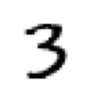

In [27]:
show_image(three_tensors[1]);  # a tensors needs fastai's function to display the image

In [28]:
three_tensors[1]  # added by me - jupyter by default prints tensors as values not images

tensor([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,  29, 150, 195, 254, 255, 254, 176, 193, 150,  96,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,  48, 166, 224, 253, 253, 234, 196, 253, 253, 253, 253, 2

In [29]:
three_tensors[1].shape  # the size is a 28 by 28; the rows by columns

torch.Size([28, 28])

In [30]:
'''
but three_tensors itself is a list; I can't easily do mathematical computations on that
we could stack these 28x28 images on top of eachother, to create like a 3d cube of images
it's still called a tensor, and to stack them up you use stack()
'''
type(three_tensors)


list

**For every pixel position**, we want to compute **the average** over all the images of the intensity of that pixel.  
**To do this we first combine all the images in this list into a single three-dimensional tensor**.  
    - three_tensors is a list and we transform it into a 3-dim tensor  
    - why 3 dims?! bc each image is 28x28 and there are 6131 images - so 3 dimensions  
    - but why the need for that? a tensor of tensors like three_tensors isn't the same? no, a tensor of tensors holds multiple tensors, and a rank-3 tensor is only one tensor!  
The most common way to describe such a tensor is to call it a **rank-3 tensor**.   
**We often need to stack up individual tensors in a collection into a single tensor.**  
Unsurprisingly, **PyTorch** comes with a function called **`stack`** that we can use for this purpose.

Some operations in PyTorch, such as **taking a mean, require us to *cast* our integer types to float types**.  
Since we'll be needing this later, we'll also cast our stacked tensor to `float` now.  
Casting in PyTorch is as simple as typing the name of the type you wish to cast to, and treating it as a method.

**Generally when images are floats, the pixel values are expected to be between 0 and 1**, so we will also divide by 255 here:

In [31]:
'''
we need the averate of all of those 3s
so the 1st thing to do is to change a list into a tensor
the shape of it is now 6131x28x28
it's like a cube of height 6131 by 28 by 28 
if we want to take the mean, we're going to turn into floating point values, because we don't want to have integers rounding off
and it's kind of a standard in computer vision that when you're working with floats, you expect them to be between 0 and 1
so we divide by 255 because they were between 0 and 255 before (the pixels)
'''
stacked_sevens = torch.stack(seven_tensors).float()/255  # stacked tensors is a single tensor with 3 dims, seven_tensors is a list of tensors rank 2 (a list of matrices; like a vector of vectors)
stacked_threes = torch.stack(three_tensors).float()/255  # mean operation needs float, and when images are floats we need values between 0 and 1
stacked_threes.shape

torch.Size([6131, 28, 28])

In [32]:
type(stacked_sevens)

torch.Tensor

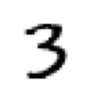

In [33]:
show_image(stacked_threes[1]);  # added by me
#stacked_threes[1]  # shows numbers between 0 and 1

Perhaps the most important attribute of a tensor is its **shape**.  
**This tells you the length of each axis.**   
In this case, we can see that we have **6,131 images, each of size 28×28 pixels**.  -> that's why 3 dims    
There is nothing specifically about this tensor that says that:  
    the first axis is the number of images,  
    the second is the height,  
    and the third is the width  
— the semantics of a tensor are entirely up to us, and how we construct it.  
As far as PyTorch is concerned, it is just a bunch of numbers in memory.

**The length of a tensor's shape is its rank**:

In [34]:
'''
this is rank 3 tensor, with 3 axis
there_tensors[1] was a rank 2 tensor, with 2 axis
numpy calls it axis, pytorch calls it dimensions 
so the rank is also the number of dimensions: ndim
'''
len(stacked_threes.shape)  

3

It is really important for you to commit to memory and practice these bits of tensor jargon:  
**_rank_ is the number of axes or dimensions in a tensor;**  
**_shape_ is the size of each axis of a tensor.**  (a list containing the size of each axis in a tensor)  

> A: Watch out because the term "dimension" is sometimes used in two ways.  
Consider that we live in "three-dimensional space" where a physical position can be described by a 3-vector `v`.  
But according to PyTorch, the attribute `v.ndim` (which sure looks like the "number of dimensions" of `v`) equals one, not three!  
Why? Because `v` is a vector, which is a tensor of rank one, meaning that it has only one _axis_ (even if that axis has a length of three).  
In other words, sometimes dimension is used for the size of an axis ("space is three-dimensional");  
other times, it is used for the rank, or the number of axes ("a matrix has two dimensions").  
When confused, I find it helpful to translate all statements into terms of rank, axis, and length, which are unambiguous terms.

We can also get a **tensor's rank** directly with **`ndim`**:

In [35]:
stacked_threes.ndim

3

**Finally, we can compute what the ideal 3 looks like.**  
We calculate **the mean of all the image tensors by taking the mean along dimension 0** of our stacked, rank-3 tensor.  
This is the dimension that indexes over all the images.  

In other words, **for every pixel position, this will compute the average of that pixel over all images.**  
**The result will be one value for every pixel position, or a single image.**  
Here it is:

In [36]:
'''
this returns a single number, that's the average pixel across the whole cube, the whole rank three tensor  
'''
stacked_threes.mean()

tensor(0.1415)

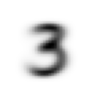

In [37]:
'''
but if we say mean(0) that means take the mean over axis 0; 
the mean across the images
'''
mean3 = stacked_threes.mean(0)  # calculate mean along dimension 0
show_image(mean3);  

In [38]:
'''
that's now 28x28 again, because we kind of like reduced over this 6131
we took the mean across that axis and so we can show that image
'''
mean3.shape

torch.Size([28, 28])

According to this dataset, this is **the ideal number 3**! (You may not like it, but this is what peak number 3 performance looks like.)  
You can see how it's very dark where all the images agree it should be dark, but it becomes wispy and blurry where the images disagree. 

Let's do **the same thing for the 7s**, but put all the steps together at once to save some time:

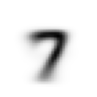

In [39]:
mean7 = stacked_sevens.mean(0)
show_image(mean7);

Let's now pick an **arbitrary 3 and measure its distance from our "ideal digits"**.

> Stop and Think!: How would you calculate how similar a particular image is to each of our ideal digits?  
Remember to step away from this book and jot down some ideas before you move on!  
Research shows that recall and understanding improves dramatically when you are engaged with the learning process by solving problems, experimenting, and trying new ideas yourself

**Here's a sample 3:**

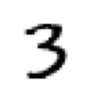

In [40]:
'''
now let's grab any 3
and now is this 3 more similar to the ideal 3 or to the ideal 7?
and whichever one it's more similar to, I'm going to assume that's the answer 
'''
a_3 = stacked_threes[1]    
show_image(a_3);

**How can we determine its distance from our ideal 3?**  
**We can't just add up the differences between the pixels of this image and the ideal digit.  
Some differences will be positive while others will be negative, and these differences will cancel out,**  
resulting in a situation where an image that is too dark in some places and too light in others might be shown as having zero total differences from the ideal.  
That would be misleading!  
(we need them all to be positive numbers  
there are 2 ways to make them all positive numbers)

To avoid this, there are **two main ways data scientists measure distance in this context**:

- Take the **mean of the *absolute value* of differences** (absolute value is the function that replaces negative values with positive values). This is called the **mean absolute difference** or **L1 norm**
- Take the **mean of the *square* of differences** (which makes everything positive) **and then take the *square root*** (which undoes the squaring). This is called the **root mean squared error** (RMSE) or **L2 norm**.

> important: It's Okay to Have Forgotten Your Math: In this book we generally assume that you have completed high school math, and remember at least some of it... But everybody forgets some things! It all depends on what you happen to have had reason to practice in the meantime. Perhaps you have forgotten what a _square root_ is, or exactly how they work. No problem! Any time you come across a maths concept that is not explained fully in this book, don't just keep moving on; instead, stop and look it up. Make sure you understand the basic idea, how it works, and why we might be using it. One of the best places to refresh your understanding is Khan Academy. For instance, Khan Academy has a great [introduction to square roots](https://www.khanacademy.org/math/algebra/x2f8bb11595b61c86:rational-exponents-radicals/x2f8bb11595b61c86:radicals/v/understanding-square-roots).

Let's try both of these now:

In [41]:
dist_3_abs = (a_3 - mean3).abs().mean()  # a_3 is a tensor from position 1 and mean3 and the average of all 3s
dist_3_sqr = ((a_3 - mean3)**2).mean().sqrt()
dist_3_abs,dist_3_sqr   # this will be used later

(tensor(0.1114), tensor(0.2021))

In [42]:
dist_7_abs = (a_3 - mean7).abs().mean()  # this time we'll compare it to the mean of the sevens
dist_7_sqr = ((a_3 - mean7)**2).mean().sqrt()
dist_7_abs,dist_7_sqr

(tensor(0.1586), tensor(0.3021))

**In both cases, the distance between our 3 and the "ideal" 3 is less than the distance to the ideal 7.**  
(0.1114 < 0.1586 and 0.2021 < 0.3021)  
So our simple model will give the right prediction in this case. (me: it's a 3)  

so it's closer to the mean of the 3s than to the mean of the 7s  
so we guess therefore that this is a 3  
so this is a good baseline

PyTorch already provides both of these as **loss functions**.  
You'll find these inside `torch.nn.functional`, which the PyTorch team recommends importing as `F` (and is available by default under that name in fastai):

In [43]:
#F.l1_loss(a_3.float(),mean7), F.mse_loss(a_3,mean7).sqrt()  # original code but float() has no sense there bc a_3 is a stacked_three[1] which is already transformed to float, and the same for mean7
F.l1_loss(a_3,mean7), F.mse_loss(a_3,mean7).sqrt()  # mse_loss doesn't do the sqrt by default so we need to pop that in

(tensor(0.1586), tensor(0.3021))

Here `mse` stands for *mean squared error*, and `l1` refers to the standard mathematical jargon for *mean absolute value* (in math it's called the *L1 norm*).

> S: Intuitively, the difference between L1 norm and mean squared error (MSE) is that the **latter (MSE) will penalize bigger mistakes more heavily than the former(L1 norm) (and be more lenient with small mistakes).**

> J: When I first came across this "L1" thingie, I looked it up to see what on earth it meant. I found on Google that it is a _vector norm_ using _absolute value_, so looked up _vector norm_ and started reading: _Given a vector space V over a field F of the real or complex numbers, a norm on V is a nonnegative-valued any function p: V → \[0,+∞) with the following properties: For all a ∈ F and all u, v ∈ V, p(u + v) ≤ p(u) + p(v)..._ Then I stopped reading. "Ugh, I'll never understand math!" I thought, for the thousandth time. Since then I've learned that every time these complex mathy bits of jargon come up in practice, it turns out I can replace them with a tiny bit of code!  
Like, the **_L1 loss_ is just equal to `(a-b).abs().mean()`**, here `a` and `b` are tensors.  
I guess mathy folks just think differently than me... I'll make sure in this book that every time some mathy jargon comes up, I'll give you the little bit of code it's equal to as well, and explain in common-sense terms what's going on.

We just completed various mathematical operations on PyTorch tensors.  
If you've done some numeric programming in NumPy before, you may recognize these as being similar to NumPy arrays.  
**Let's have a look at those two very important data structures.**

### NumPy Arrays and PyTorch Tensors

**[NumPy](https://numpy.org/)** is the most widely used library for scientific and numeric programming in Python.  
It provides very similar functionality and a very similar API to that provided by PyTorch;  
however, **it does not support using the GPU or calculating gradients**, which are both critical for deep learning.  
Therefore, in this book **we will generally use PyTorch tensors instead of NumPy arrays**, where possible.  

(Note that fastai adds some features to NumPy and PyTorch to make them a bit more similar to each other.  
If any code in this book doesn't work on your computer, it's possible that you forgot to include a line like this at the start of your notebook: `from fastai.vision.all import *`.)

But what are arrays and tensors, and why should you care?

Python is slow compared to many languages. Anything fast in Python, NumPy, or PyTorch is likely to be a wrapper for a compiled object written (and optimized) in another language—specifically C.  
In fact, **NumPy arrays and PyTorch tensors can finish computations many thousands of times faster than using pure Python.**

**A NumPy array is a multidimensional table of data, with all items of the same type.**  
Since that can be any type at all, they can even be arrays of arrays, with **the innermost arrays potentially being different sizes—this is called a "jagged array."** (ca un fierastrau)  
By "multidimensional table" we mean, for instance, a list (dimension of one), a table or matrix (dimension of two), a "table of tables" or "cube" (dimension of three), and so forth.  
**If the items are all of some simple type such as integer or float, then NumPy will store them as a compact C data structure in memory.**  
This is where NumPy shines. NumPy has a wide variety of operators and methods that can run computations on these compact structures at the same speed as optimized C, because they are written in optimized C.

**A PyTorch tensor** is nearly the same thing as a NumPy array, but with **an additional restriction that unlocks some additional capabilities.**  
It's the same in that it, too, is a multidimensional table of data, with all items of the same type.  
**However, the restriction is that a tensor cannot use just any old type—it has to use a single basic numeric type for all components.**     
For example, **a PyTorch tensor cannot be jagged. It is always a regularly shaped multidimensional rectangular structure.**  

The vast majority of methods and operators supported by NumPy on these structures are also supported by PyTorch, but **PyTorch tensors have additional capabilities**.  
One major capability is that **these structures can live on the GPU, in which case their computation will be optimized for the GPU and can run much faster** (given lots of values to work on).  
In addition, PyTorch can automatically **calculate derivatives** of these operations, including combinations of operations.  
As you'll see, it would be impossible to do deep learning in practice without this capability.  

> S: If you don't know what C is, don't worry as you won't need it at all. In a nutshell, it's a low-level  (low-level means more similar to the language that computers use internally) language that is very fast compared to Python.  
**To take advantage of its speed while programming in Python, try to avoid as much as possible writing loops, and replace them by commands that work directly on arrays or tensors.**

Perhaps the most important new coding skill for a Python programmer to learn is how to **effectively use the array/tensor APIs**.  
We will be showing lots more tricks later in this book, but **here's a summary** of the key things you need to know for now.

**To create an array or tensor,  
pass a list (or list of lists, or list of lists of lists, etc.)  
to `array()` or `tensor()`:**

In [44]:
data = [[1,2,3],[4,5,6]]
arr = array (data)
tns = tensor(data)

In [45]:
arr  # numpy

array([[1, 2, 3],
       [4, 5, 6]])

In [46]:
tns  # pytorch

tensor([[1, 2, 3],
        [4, 5, 6]])

All the operations that follow are shown on tensors, but the syntax and results for NumPy arrays is identical.

**You can select a row** (note that, like lists in Python, tensors are 0-indexed so 1 refers to the second row/column):

In [47]:
tns[1]  # row 1; the 2nd row

tensor([4, 5, 6])

or **a column**, by using **`:` to indicate *all of the first axis*** (we sometimes refer to the dimensions of tensors/arrays as *axes*):

In [48]:
tns[:,1]  # 1st position shows the row, 2nd position shows the column

tensor([2, 5])

You can combine these with Python **slice syntax (`[start:end]` with `end` being excluded)** to select part of a row or column:

In [49]:
tns[1,1:3]   # row 1, columns 1,2 (not 3)

tensor([5, 6])

And you can use the standard operators such as `+`, `-`, `*`, `/`:

In [50]:
tns+1

tensor([[2, 3, 4],
        [5, 6, 7]])

Tensors have a **type**:

In [51]:
tns.type()

'torch.LongTensor'

In [52]:
'''
this is different from python type, which is a method
this tells you it's a tensor
if you want to know what kind of a tensor, you have to use type as a method: tns.type()
'''
type(tns)

torch.Tensor

And will **automatically change type as needed**, for example from `int` to `float`:

In [53]:
tns*1.5

tensor([[1.5000, 3.0000, 4.5000],
        [6.0000, 7.5000, 9.0000]])

**So, is our baseline model any good?  
Our model that compares something to the mean  
To quantify this, we must define a metric**.

## Computing Metrics Using Broadcasting

Recall that **a metric is a number that is calculated based on the predictions of our model, and the correct labels in our dataset, in order to tell us how good our model is**.  
For instance, we could use either of the functions we saw in the previous section, **mean squared error, or mean absolute error, and take the average of them over the whole dataset.**   
However, neither of these are numbers that are very understandable to most people;  
in practice, we normally **use accuracy as the metric for classification models**.  

As we've discussed, we want to **calculate our metric over a validation set**.  
This is so that we don't inadvertently **overfit—that is, train a model to work well only on our training data**.  
This is not really a risk with the pixel similarity model we're using here as a first try, since it has no trained components,  
but we'll use a validation set anyway to follow normal practices and to be ready for our second try later.

To get a validation set we need to remove some of the data from training entirely, so it is not seen by the model at all.  
As it turns out, the creators of the MNIST dataset have already done this for us.  
Do you remember how there was a whole separate **directory called *valid***? That's what this directory is for!

So to start with, **let's create tensors for our 3s and 7s from that directory (valid)**.  
**These are the tensors we will use to calculate a metric measuring the quality of our first-try model, which measures distance from an ideal image**:

In [54]:
valid_3_tens = torch.stack([tensor(Image.open(o)) for o in (path/'valid'/'3').ls()])  # combine all the steps for valids
valid_3_tens = valid_3_tens.float()/255
#
valid_7_tens = torch.stack([tensor(Image.open(o)) for o in (path/'valid'/'7').ls()])
valid_7_tens = valid_7_tens.float()/255
#
valid_3_tens.shape, valid_7_tens.shape   # they are just 1k because it's the validation set

(torch.Size([1010, 28, 28]), torch.Size([1028, 28, 28]))

It's good to get in **the habit of checking shapes** as you go.  
Here we see two tensors, one representing the 3s validation set of 1,010 images of size 28×28, and one representing the 7s validation set of 1,028 images of size 28×28.

==

We ultimately want to write **a function, `is_3`, that will decide if an arbitrary image is a 3 or a 7.  
(will return true if something is a 3)**    
**It will do this by deciding which of our two "ideal digits" this arbitrary image is closer to.**  
(to do that we have to decide whether our digit that we're testing on is closer to the ideal 3 or to ideal 7)  
For that we need to define **a notion of distance  
— that is, a function that calculates the distance between two images**.  

We can write a simple **function that calculates the mean absolute error** using an expression very similar to the one we wrote in the last section:  
(takes distance between 2 tensors, takes the absolute value and then takes the mean)

In [55]:
'''
the mean over the last and the second last dimensions (0 is the 1st, -1 is the last, -2 is the second last)
so this is going to take the mean acros the x and y axis
'''

def mnist_distance(a,b):               
    return (a-b).abs().mean((-1,-2))   # why -1,-2? https://forums.fast.ai/t/understanding-mean-1-2-in-mnist-distance/84430
mnist_distance(a_3, mean3)             # same as dist_a3_abs, cell 27

tensor(0.1114)

This is **the same value** we previously calculated for the **distance between these two images,  
the ideal 3, `mean3` and the arbitrary sample 3 `a_3`,**    
which are both single-image tensors with a shape of `[28,28]`.

But in order to calculate **A METRIC FOR OVERALL ACCURACY**,  
**we will need to calculate the distance to the ideal 3 for _every_ image in the validation set**.  
How do we do that calculation?  
We could write a loop over all of the single-image tensors that are stacked within our validation set tensor,  
`valid_3_tens`, which has a shape of `[1010,28,28]` representing 1,010 images.  
But there is a better way.  

Something very interesting happens when **we take this exact same distance function,  
designed for comparing two single images,  
but pass in as an argument `valid_3_tens`,  
the tensor that represents the 3s validation set** (a rank-3 tensors):

In [56]:
'''
mnist_distance:
    takes the difference between different tensors with broadcasting
    then we say the absolute value on something of size 1010x28x28 (difference.shape) 
    it just calls abs value on each underlying thing
    and finally, we call mean: -1 is the last element in python, -2 is the second last
    so this is taking the mean over the last 2 axis
    and it's going to return just the 1st axis - meaning 1010 elements, each element is the mean of a 784 (28x28) pixels
    which is what we want: to know how far away is each of our validation items from the ideal 3
'''
valid_3_dist = mnist_distance(valid_3_tens, mean3)
valid_3_dist, valid_3_dist.shape, valid_3_dist.ndim

(tensor([0.1086, 0.1092, 0.1124,  ..., 0.1368, 0.1382, 0.1187]),
 torch.Size([1010]),
 1)

In [57]:
valid_3_tens.shape

torch.Size([1010, 28, 28])

In [58]:
'''
because they don't match it acts like as if there's a 1010 versions of this 28x28 of this mean3
so it's going to substract mean3 from every single valid_3_tens 
'''
mean3.shape

torch.Size([28, 28])

Instead of complaining about shapes not matching,  
it returned the **distance for every single image as a vector (i.e., a rank-1 tensor) of length 1,010** (the number of 3s in our validation set).  
How did that happen?

Take another look at our function `mnist_distance`, and you'll see we have there the subtraction `(a-b)`.  
The magic trick is that PyTorch, when it tries to perform a simple subtraction operation between two tensors of different ranks, will use **broadcasting**.  
That is, **it will automatically expand the tensor with the smaller rank to have the same size as the one with the larger rank**.  
Broadcasting is an important capability that makes tensor code much easier to write.

After broadcasting so the two argument tensors have the same rank,  
PyTorch applies its usual logic for two tensors of the same rank:  
it performs the operation on each corresponding element of the two tensors, and returns the tensor result.  
For instance:

In [59]:
'''
element wise operations - adds each element
'''
tensor([1,2,3]) + tensor([1,1,1])

tensor([2, 3, 4])

In [60]:
'''
when I have different shapes, it copies 1 for 3 times
'''
tensor([1,2,3]) + tensor(1)

tensor([2, 3, 4])

So in this case, PyTorch **treats `mean3`, a rank-2 tensor representing a single image, as if it were 1,010 copies of the same image**,  
and then subtracts each of those copies from each 3 in our validation set.  
What shape would you expect this tensor to have?  
Try to figure it out yourself before you look at the answer below:

In [61]:
'''
valid_3_tens minus 1010 copies of mean3
'''
(valid_3_tens-mean3).shape

torch.Size([1010, 28, 28])

We are calculating **the difference between our "ideal 3" and each of the 1,010 3s in the validation set, for each of 28×28 images, resulting in the shape `[1010,28,28]`**.

There are a couple of **important points about how broadcasting is implemented**, which make it valuable not just for expressivity but also for **performance**:

- **PyTorch doesn't *actually* copy `mean3` 1,010 times. It *pretends* it were a tensor of that shape, but doesn't actually allocate any additional memory**  
- **It does the whole calculation in C (or, if you're using a GPU, in CUDA, the equivalent of C on the GPU)**, tens of thousands of times faster than pure Python (up to millions of times faster on a GPU!).

**This is true of all broadcasting and elementwise operations and functions done in PyTorch.  
*It's the most important technique for you to know to create efficient PyTorch code.***

Next in `mnist_distance` we see **`abs`**. You might be able to guess now what this does when applied to a tensor.  
**It applies the method to each individual element in the tensor, and returns a tensor of the results (that is, it applies the method "elementwise").**    
So in this case, we'll get back **1,010 matrices of absolute values**. (1010x(28x28))

**Finally, our function calls `mean((-1,-2))`**.  
The tuple `(-1,-2)` represents **a range of axes**.  
In Python, `-1` refers to the *last element*, and `-2` refers to the *second-to-last*.  
So in this case, **this tells PyTorch that we want to take the mean ranging over the values indexed by the last two axes of the tensor.  
The last two axes are the horizontal and vertical dimensions of an image. (me: the 28x28 axis of each image)  
After taking the mean over the last two axes, we are left with just the first tensor axis,  
which indexes over our images, which is why our final size was `(1010 means)`.**  
**In other words, for every image, we averaged the intensity of all the pixels in that image.**  (so not the average of every pixel from the axis 0, but the average of every image 28x28)

We'll be learning lots more about broadcasting throughout this book, especially in <<chapter_foundations>>, and will be practicing it regularly too.

We can use `mnist_distance` to figure out whether **an image is a 3 or not** by using the following logic:  
**if the distance between the digit in question and the ideal 3 is less than the distance to the ideal 7, then it's a 3.**  
This function will automatically do broadcasting and be applied elementwise, just like all PyTorch functions and operators:

In [62]:
'''
is the distance between the number in question and the perfect 3 less than 
the distance between the number in question and the perfect 7?
if it is, it's a 3
'''

def is_3(x): return mnist_distance(x,mean3) < mnist_distance(x,mean7)

**Let's test it on our example case:**

In [63]:
is_3(a_3), is_3(a_3).float()  # we can turn that into a float and yes becomes 1

(tensor(True), tensor(1.))

Note that when we convert the Boolean response to a float, we get `1.0` for `True` and `0.0` for `False`.  
**Thanks to broadcasting, we can also test it on the full validation set of 3s:**

In [64]:
'''
thanks to broadcasting, we can do it for the entire validation set of 3s
we basically get rid of loops
in this kind of programming, you should have very few loops
loops make things much harder to read, and hundreds of thousands of times slower
on gpu potentially tens of millions of times slower
'''
is_3(valid_3_tens)  

tensor([True, True, True,  ..., True, True, True])

In [65]:
is_3(valid_3_tens).float()  # added by me

tensor([1., 1., 1.,  ..., 1., 1., 1.])

Now we can calculate **the accuracy for each of the 3s and 7s by taking the average of that function for all 3s and its inverse for all 7s:**

In [66]:
'''
so the accuracy across 3s is about 91%, on 7 is 98%
and the average of those 2 is about 95%
so here we have a model that's 95% accurate in recognising 3s from 7s
it can suprise you that we can do that nothing but arithmetic
so that's what I mean by getting a good baseline

but it doesn't match Arthur Samuel description of machine learning
this is not something where there's a function which has some parameters
which we're testing against some kind of measure of fitness
and then using that to like improve the parameters iteratively

here we just did one step and that's that
'''
accuracy_3s =      is_3(valid_3_tens).float() .mean()
accuracy_7s = (1 - is_3(valid_7_tens).float()).mean()

accuracy_3s,accuracy_7s,(accuracy_3s+accuracy_7s)/2  # me: it's 0.90 because some of the is_3 are not 1 but 0 or 0.5 etc

(tensor(0.9168), tensor(0.9854), tensor(0.9511))

In [67]:
(1-is_3(valid_7_tens).float()).mean()

tensor(0.9854)

This looks like a pretty good start! We're getting **over 90% accuracy on both 3s and 7s,** (me: because some of the is_3 are not 1 but 0 or 0.5 etc)  
and we've seen how to define a metric conveniently using broadcasting.

But let's be honest: 3s and 7s are very different-looking digits.  
And we're only classifying 2 out of the 10 possible digits so far.  
So we're going to need to do better!

To do better, perhaps it is time to **try a system that does some real learning
— that is, that can automatically modify itself to improve its performance.**  
In other words, it's time to talk about **the training process, and SGD.**

## Stochastic Gradient Descent (SGD)

Do you remember the way that Arthur Samuel **described machine learning**, which we quoted in <<chapter_intro>>?

> **Suppose we arrange for some automatic means  
of testing the effectiveness of any current weight (parameter) assignment in terms of actual performance  
and provide a mechanism for altering the weight assignment so as to maximize the performance.  
We need not go into the details of such a procedure to see that it could be made entirely automatic  
and to see that a machine so programmed would "learn" from its experience.**

As we discussed, this is the key to allowing us to have **a model that can get better and better — that can learn.**  
**But our pixel similarity approach does not really do this.**  
We do not have any kind of weight assignment, or any way of improving based on testing the effectiveness of a weight assignment.  
In other words, **we can't really improve our pixel similarity approach by modifying a set of parameters.**    
**In order to take advantage of the power of deep learning,  
we will first have to represent our task in the way that Arthur Samuel described it.**

Instead of trying to find the similarity between an image and an "ideal image,"  
we could instead **look at each individual pixel and come up with a set of weights for each one,  
such that the highest weights are associated with those pixels most likely to be black for a particular category.**  
For instance, **pixels toward the bottom right** are not very likely to be activated for a 7, so they should have **a low weight for a 7,**  
but they are likely to be activated for an 8, so they should have **a high weight for an 8.**  
This can be represented as **a function and set of weight values for each possible category  
— for instance the probability of being the number 8:**

```
def pr_eight(x,w): return (x*w).sum()
```
> why this formula? a nn multiplies each input by a number of values and adds them (how a nn works)

In [68]:
'''
instead of finding an ideal image and seeing how far away something is from the ideal image
we could come up with a set of weights for each pixel
so we're trying to find out if something is the number 3
and so we know that like in the places that you would expect to find 3 pixels you could give those high weights
if there's a dot in those places, we give it like a high score 
and if there's dots in other places we give it a low score (why?)

so we can actually come up with a function where the probability of something being an 8
is equal to pixels in the image (x) multiplied by some sort of weights and them we sum them up
so then anywhere where the image we're looking at has pixels (where) there are high weights
it's going to end up with high probability 

here X is the image, represented as vector, have all the rows stacked up, end to end into a single long line

so we're going to use an approach were we're going to start with a vector W (rank 1 tensor)
1. that's going to contain random weights (random parameters)
2. we'll then predict whether a number appears to be a 3 or a 7 by using this tiny little function pr_eight
3. and then we'll figure out how good/accurate our model is (it's loss)
4. and then the key step is to calculate the gradient
the gradient is something that measures for each weight 
if I made it a little bit bigger would the loss get better or worse
if I made it a little bit smaller would the loss get better or worse?
so if we do that for every weight we can decide for every weight whether we should make that weight a bit bigger or a bit smaller
that's called the gradient
5. once we have the gradient we then step (change) all the weights 
up a little bit for the ones where the gradient said we should make them a bit higher
and down a little bit for all the once where the gradient said they should be a little bit lower
so now it should be a tiny bit better 
6. and then we go back to step 2 and calculate a new set of predictions, using this formula
calculate the gradient again, step the weights, keep doing that
this is the flow chart 
7. and at somw point when we're sick of waiting or when the loss gets good enough we'll stop

these 7 steps are key to training all DL models
this technique is called stochastic gradient descent 
well, it's gradient descent, we'll the see the stochastic very soon
'''

"\ninstead of finding an ideal image and seeing how far away something is from the ideal image\nwe could come up with a set of weights for each pixel\nso we're trying to find out if something is the number 3\nand so we know that like in the places that you would expect to find 3 pixels you could give those high weights\nif there's a dot in those places, we give it like a high score \nand if there's dots in other places we give it a low score (why?)\n\nso we can actually come up with a function where the probability of something being an 8\nis equal to pixels in the image (x) multiplied by some sort of weights and them we sum them up\nso then anywhere where the image we're looking at has pixels (where) there are high weights\nit's going to end up with high probability \n\nhere X is the image, represented as vector, have all the rows stacked up, end to end into a single long line\n\nso we're going to use an approach were we're going to start with a vector W (rank 1 tensor)\n1. that's goi

Here we are assuming that **`x` is the image, represented as a vector**  
— in other words, with <u>all of the rows stacked up end to end into a single long line</u>.    
And we are assuming that **the weights are a vector `w`**.  
If we have this function, then we just need some **way to update the weights to make them a little bit better**.  
With such an approach, we can repeat that step a number of times,  
making the weights better and better, until they are as good as we can make them.

**We want to find the specific values for the vector `w`  
that causes the result of our function to be high for those images that are actually 8s,  
and low for those images that are not.**  
**Searching for the best vector `w` is a way to search for the best function for recognising 8s.**  
(<u>Because we are not yet using a deep neural network, we are limited by what our function can actually do</u>.  
— we are going to fix that constraint later in this chapter.) 

To be more specific, here are **the steps** that we are going to require,  
**to turn this function into a machine learning classifier:**

1. ***Initialize*** the weights.
1. For each image, **use these weights to *predict*** whether it appears to be a 3 or a 7.
1. Based on these predictions, **calculate how good the model is (its *loss*).**
1. **Calculate the *gradient***, <u>which measures for each weight, how changing that weight would change the loss</u>
1. ***Step* (that is, change) all the weights** based on that calculation.
1. Go back to the **step 2, and *repeat*** the process.
1. **Iterate until you decide to *stop*** the training process (for instance, because the model is good enough or you don't want to wait any longer).

**These seven steps, illustrated in <<gradient_descent>>, are the key to the training of all deep learning models.**    
That deep learning turns out to rely entirely on these steps is extremely surprising and **counterintuitive**.  
It's amazing that this process can solve such complex problems.  
But, as you'll see, it really does!

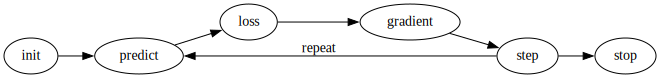

In [69]:
#id gradient_descent
#caption The gradient descent process
#alt Graph showing the steps for Gradient Descent
gv('''
init->predict->loss->gradient->step->stop
step->predict[label=repeat]
''')

In [70]:
'''
for each of these 7 steps there are lots of choices around exactly how to do it
we've just kind of hand waved a lot
    what kind of random initialization
    how do you calculate the gradient
    and what step do you take based on the gradient
    and how do you decide when to stop

in this course we're going to be learning about these steps, that's kind of the part 1
the other part is what is the actual function, neural network
so how do we train the thing that we train?

so we initialize the parameters with random values
we need some function that's going to be the loss function that will return a number that's small if the performance of the model is good
some way to figure out if the weight should be increased or decreased a bit 
and then we need to decide when to stop, which is to say let's do a certain number of epochs

1.45
'''

"\nfor each of these 7 steps there are lots of choices around exactly how to do it\nwe've just kind of hand waved a lot\n    what kind of random initialization\n    how do you calculate the gradient\n    and what step do you take based on the gradient\n    and how do you decide when to stop\n\nin this course we're going to be learning about these steps, that's kind of the part 1\nthe other part is what is the actual function, neural network\nso how do we train the thing that we train?\n\nso we initialize the parameters with random values\nwe need some function that's going to be the loss function that will return a number that's small if the performance of the model is good\nsome way to figure out if the weight should be increased or decreased a bit \nand then we need to decide when to stop, which is to say let's do a certain number of epochs\n\n1.45\n"

**There are many different ways to do each of these seven steps**, and we will be learning about them throughout the rest of this book.  
These are the details that make a big difference for deep learning practitioners,  
but it turns out that **the general approach to each one generally follows some basic principles**.  
**Here are a few guidelines:**

- **Initialize**:: **We initialize the parameters to random values**.  
This may sound surprising.  
There are certainly other choices we could make, such as initializing them to the percentage of times that pixel is activated for that category  
— but since we already know that we have a routine to improve these weights, it turns out that just starting with random weights works perfectly well.   
- **Loss**:: This is what Samuel referred to when he spoke of ***testing the effectiveness of any current weight assignment in terms of actual performance***.  
**We need some function that will return a number that is small if the performance of the model is good**  
(the standard approach is to treat a small loss as good, and a large loss as bad, although this is just a convention).  
- **Step**:: A simple way to **figure out whether a weight should be increased a bit, or decreased a bit**,  
would be just to try it: **increase the weight by a small amount, and see if the loss goes up or down.**    
Once you find the correct direction, you could then change that amount by a bit more, and a bit less,  
until you find an amount that works well.  
However, this is slow! As we will see, the magic of calculus allows us  
**to directly figure out in which direction, and by roughly how much, to change each weight,**  
without having to try all these small changes.  
The way to do this is by calculating ***gradients***.  
This is just a performance optimization, we would get exactly the same results by using the slower manual process as well.  
- **Stop**:: Once we've decided **how many epochs to train the model for** (a few suggestions for this were given in the earlier list),  
we apply that decision. This is where that decision is applied.  
For our digit classifier, we would **keep training until the accuracy of the model started getting worse, or we ran out of time.**   

Before applying these steps to our image classification problem, **let's illustrate what they look like in a simpler case.**    
First we will define a very simple function,  
**the quadratic — let's pretend that this is our loss function, and `x` is a weight parameter of the function:**  
>me: why x is the weight parameter?  
we need to minimize the loss function  
and the loss is a function of the weight (in this case a quadratic function, but it can be some other function)  
why loss is a function of the weight? because we need to find the weights where the loss is minimum!!  
more logical would be f(a)=a**2

In [71]:
'''
so let's go even simpler, we're not going to do mnist
we're going to start with this x**2
and in fastai we've created a tiny thing called plot function
that plots a function 
'''
def f(x): return x**2

Here is a **graph** of that function:

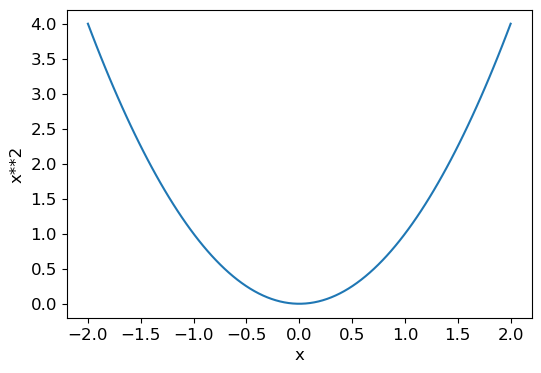

In [72]:
plot_function(f, 'x', 'x**2')

The sequence of steps we described earlier 
**starts by picking some random value for a parameter, 
and calculating the value of the loss:**  
> me: step 1 initialize the weights or parameters;  
> so if it says pick a random value for a parameter then x is the parameter, -1.5  
x=-1.5 and the loss is f(-1.5) because quadratic f is the loss  

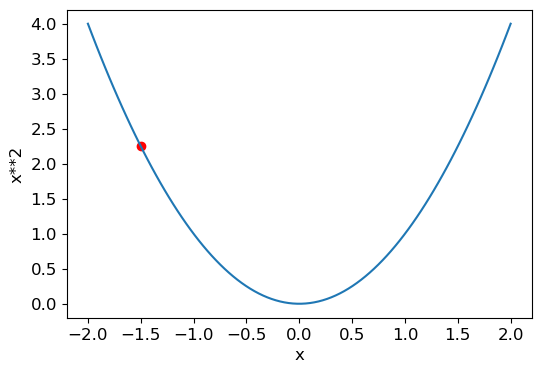

In [73]:
'''
so there's our loss function f, 
and we're going to do is we're going to try to find the bottom point
we're trying to figure out what is the x value, which is at the bottom
so our seven stop procedure requires us to start out by initializing the weights
so we need to pick some value
so the value we pick is just randomly -1.5

so now we need to know if I increased x a bit, does my loss gets a bit better
better is smaller, going down, or a bit worse?
we can try a slightly higher x, a lower x and see what happens

and you can see it's just the slope
the slope at this point (X=-1.5) tells you that if I increased x by a bit then 
my loss will decrease because that is the slope at this point
so if we change our weight, our parameter, just a little bit, in the direction of the slope

here is the direction of the slope; the big red, horizontal line
here is the new value at that point, intersect of the verticall dotted line with the function
and then do it again
and then do it again
eventually we'll get to the bottom of this curve
'''
plot_function(f, 'x', 'x**2')
plt.scatter(-1.5, f(-1.5), color='red');

Now we look to see **what would happen if we increased or decreased our parameter by a little bit — the *adjustment***.  
This is simply **the slope** at a particular point:

<img alt="A graph showing the squared function with the slope at one point" width="400" src="images/grad_illustration.svg"/>

We can 
**change our weight by a little in the direction of the slope, (me: increase the parameter/weight)    
calculate our loss and adjustment again,  
and repeat this a few times**.   
Eventually, we will get to **the lowest point on our curve**:

here is the direction of the slope; the big red, horizontal line  
here is the new value at that point, intersect of the verticall dotted line with the function  
and then do it again  
and then do it again  
eventually we'll get to the bottom of this curve  

<img alt="An illustration of gradient descent" width="400" src="images/chapter2_perfect.svg"/>

This basic idea goes all the way back to **Isaac Newton**, who pointed out that we can optimize arbitrary functions in this way.  
Regardless of how complicated our functions become, **this basic approach of gradient descent will not significantly change**.  
The only minor changes we will see later in this book are **some handy ways we can make it faster, by finding better steps**.

video:
the idea is called newton's method  
so a key thing we need to be able to do is to calculate this slope  
the bad news is to do that we need calculus  
we have to calculate the derivative  
1.48.55  

### Calculating Gradients

**The one magic step is the bit where we calculate the gradients**.    
As we mentioned, we use calculus as a performance optimization;  
it allows us to more quickly **calculate whether our loss will go up or down when we adjust our parameters up or down**.  
In other words, **the gradients will tell us how much we have to change each weight to make our model better**.

You may remember from your high school calculus class that  
**the *derivative* of a function tells you how much a change in its parameters will change its result**.   
If not, don't worry, lots of us forget calculus once high school is behind us!  
But you will have to have some intuitive understanding of what a derivative is before you continue,  
so if this is all very fuzzy in your head, head over to Khan Academy and complete the **[lessons on basic derivatives](https://www.khanacademy.org/math/differential-calculus/dc-diff-intro)**.  
You won't have to know how to calculate them yourselves, **you just have to know what a derivative is.**

**The key point about a derivative is this:** <u>for any function, such as the quadratic function we saw in the previous section, we can calculate its derivative</u>.  
The derivative is another function.  
**It calculates the change, rather than the value.**  
For instance, **the derivative of the quadratic function at the value 3 tells us how rapidly the function changes at the value 3.  
= THE SPEED**   
More specifically, you may recall that **gradient** is defined as ***rise/run***,  
that is, **<u>the change in the value of the function, divided by the change in the value of the parameter</u>**.  
**When we know how our function will change, then we know what we need to do to make it smaller**.  
>(me: because slope=rise/run or delta-function/delta-parameter and is negative  
and delta-func is negative because the func value is lower  
then we need to increase the param so that delta-param is positive so that the slope is negative  
if the param would decrease then delta-param would be negative and the slope positive, but that's not the case)         

**This is the key to machine learning: having a way to change the parameters of a function to make it smaller**.  
Calculus provides us with a computational shortcut, **the derivative, which lets us directly calculate the gradients of our functions**.  

One important thing to be aware of is that **our function has lots of weights** that we need to adjust,  
so when we **calculate the derivative** we won't get back one number, but lots of them — **a gradient for every weight**.  
But there is nothing mathematically tricky here;  
you can calculate **the derivative with respect to one weight, and treat all the other ones as constant,  
then repeat that for each other weight**.   
This is how all of the gradients are calculated, for every weight.

We mentioned just now that you won't have to calculate any gradients yourself. How can that be?  
Amazingly enough, **PyTorch is able to automatically compute the derivative of nearly any function!**  
What's more, it does it very fast.  
Most of the time, it will be at least as fast as any derivative function that you can create by hand.  
Let's see **an example.**

First, **let's pick a tensor value which we want gradients at:** (me: the parameter is 3)

In [74]:
'''
we start with a tensor, and we'll modify this tensor with this special method called requires_grad_
and this tells pytorch that any time I do a calculation with this xt
it should remember what calculation it does so that I can take the derivative later 
_ at the end of a method in pytorch means this is called an in-place operation: it actually modifies tensor(3.)
so requires_grad_ modifies this tensor to tell pytorch that we want to be calculation gradients on it
so that means it's just going to keep track of all of the computations we do so that it can calculate the derivative later
'''
xt = tensor(3.).requires_grad_()  # xt = xtensor?!

Notice the special method `requires_grad_`?  
That's the magical incantation we use to tell PyTorch that we want to **calculate gradients with respect to that variable at that value.**    
**It is essentially tagging the variable,** so PyTorch will remember to   
**keep track of how to compute gradients of the other, direct calculations on it that you will ask for**.  

> a: This API might throw you off if you're coming from math or physics.  
In those contexts the "gradient" of a function is just another function (i.e., its derivative),  
so you might expect gradient-related APIs to give you a new function.  
**But in deep learning, "gradients" usually means the _value_ of a function's derivative at a particular argument value.**  
The PyTorch API also puts the focus on the argument, not the function you're actually computing the gradients of.  
It may feel backwards at first, but it's just a different perspective.  

**Now we calculate our function with that value.**  
Notice how PyTorch prints not just the value calculated,  
but also a note that it has a gradient function it'll be using to calculate our gradients when needed:

In [75]:
'''
ok, so we've got the number 3 and call f on it
f(3)=9 but the value is not just 9
it's 9 accompanied with a grad function which it knows that a power operation has been taken
'''
yt = f(xt)  # xt is 3 so yt is the loss at 3
yt

tensor(9., grad_fn=<PowBackward0>)

**Finally, we tell PyTorch to calculate the gradients for us:**

In [76]:
'''
so we can now call a special method, backward
which refers to backpropagation, and it means take the derivative
'''
yt.backward()

**The "backward" here refers to *backpropagation***,  
which is the name given to **the process of calculating the derivative of each layer**.   
We'll see how this is done exactly in chapter <<chapter_foundations>>,  
when we calculate the gradients of a deep neural net from scratch.  
This is called **the "backward pass" of the network, as opposed to the "forward pass,"**    
which is where the activations are calculated.  
Life would probably be easier if `backward` was just called `calculate_grad`,  
but deep learning folks really do like to add jargon everywhere they can!  

**We can now view the gradients by checking the `grad` attribute of our tensor:**

In [77]:
'''
once it does that, we can now look inside xt, which we said it requires grad
and find out its gradient
and remember, the derivative of x**2 is 2*x
in this case 2*3=6 
so we didn't have to figure out the derivative, 
we just called backward and then get the grad attribute to get the derivative
so that's how easy it is to do calculus in pytorch

so what you need to know about calculus is not how to take a derivative, but what it means
and what it means it's a slope at some point

'''
xt.grad

tensor(6.)

If you remember your high school calculus rules, the derivative of `x**2` is `2*x`,  
and we have `x=3`, so the gradients should be `2*3=6`, which is what PyTorch calculated for us!

Now we'll repeat the preceding steps, **but with a vector argument for our function:**

In [78]:
'''
something interesting, let's not just take 3, let's take a rank1 tensor, also known as a vector
'''

xt = tensor([3.,4.,10.]).requires_grad_()  # weights are 3,4,10 and are inputs for the loss function f(x)
xt

tensor([ 3.,  4., 10.], requires_grad=True)

And we'll add **`sum`** to our function so it can **take a vector (i.e., a rank-1 tensor), and return a scalar (i.e., a rank-0 tensor):**  
> why it needs to return a scalar? because you need to see if the loss function increases or decreases if you modify the weight/parameter x  
> true, because it says "pretend the quadratic is our loss function"  
> and the derivative of the quadratic shows if the loss function increases or decreases  

In [79]:
'''
and let's add sum to our f function
f of this vector is 125 
'''
def f(x): return (x**2).sum()

yt = f(xt)
yt  # loss is 125=9+16+100

tensor(125., grad_fn=<SumBackward0>)

**Our gradients are `2*xt`, as we'd expect!**

In [80]:
'''
and we say backward and grad
and it's 2x,2x,2x
so this is vector calculus
we're getting the gradient for every element of a vector with the same 2 lines of code
so that's all you need to know about calculus

so now that we know how to calculate the gradient, that is the slope of the function
that tells us if we change our input a little bit, how will our output change correspondingly
that's what a slope is

and so that tells us that for every one of our parameters, if we know their gradients
then we know if we change that parameter up a bit or down a bit, how it will change our loss
so therefore, we then know how to change our parameters

'''
yt.backward()  # yt.calculate_grad() for ytensor which is the loss function; 
xt.grad        # calculate_gradients() means to derivate the loss, and it shows in which direction is the minimum

tensor([ 6.,  8., 20.])

**The gradients only tell us the slope of our function, they don't actually tell us exactly how far to adjust the parameters.**  
> me: but why the grad is attached to xt? because the gradients show how much each weight needs to change 

**But it gives us some idea of how far;**  
if the slope is **very large, then that may suggest that we have more adjustments to do,**  
**hereas if the slope is very small, that may suggest that we are close to the optimal value.**  
>me: very large means very far from minimum of the loss functions, where the gradient/slope is 0 (an horizontal line)

### Stepping With a Learning Rate

Deciding **how to change our parameters based on the values of the gradients** is an important part of the deep learning process.  
Nearly all approaches start with the basic idea of 
**multiplying the gradient by some small number, called the *learning rate* (LR).**    
The learning rate is often a number between **0.001 and 0.1**, although it could be anything.  
Often, people select a learning rate just by trying a few, and finding which results in the best model after training  
(we'll show you a better approach later in this book, called the *learning rate finder*).  
Once you've picked a learning rate, you can **adjust your parameters** using this simple function:

```
w -= gradient(w) * lr
```

This is known as ***stepping*** your parameters, using an ***optimizer step***.  
Notice how we **_subtract_ the `gradient * lr` from the parameter to update it.**  
This allows us to **adjust the parameter in the direction of the slope**  
<u>by increasing the parameter when the slope is negative and decreasing the parameter when the slope is positive</u>.  
**We want to adjust our parameters in the direction of the slope because our goal in deep learning is to _minimize_ the loss**.

If you pick a **learning rate that's too low**, it can mean having to do a lot of steps. <<descent_small>> illustrates that.



In [81]:
'''
let's say all of our weights are called "w",
we just substract off them the gradients multiplied by some small number 
and that small number is often a number between 0.001 and 0.1
and it's called the learning rate

w -= gradient(w) * lr

and this here is the essence of gradient descent
so if you pick a learning rate that is very small, then you take a small step in the direction of the slope
and another small step, so on
and it's going to take forever to get to the end
'''

'\nlet\'s say all of our weights are called "w",\nwe just substract off them the gradients multiplied by some small number \nand that small number is often a number between 0.001 and 0.1\nand it\'s called the learning rate\n\nw -= gradient(w) * lr\n\nand this here is the essence of gradient descent\nso if you pick a learning rate that is very small, then you take a small step in the direction of the slope\nand another small step, so on\nand it\'s going to take forever to get to the end\n'

<img alt="An illustration of gradient descent with a LR too low" width="400" caption="Gradient descent with low LR" src="images/chapter2_small.svg" id="descent_small"/>

But picking a **learning rate that's too high** is even worse — it can actually result in the loss getting *worse*, as we see in <<descent_div>>!

In [82]:
'''
if you pick a learning rate that is too big, you jump way too far each time and again, it's goint to take forever
me: why like this? because w is on the x/parameter axis and if lr is big then new w is that big
it started at the bottom and lr is so bit that w got worse and worse, it moves away from the minimum
'''

"\nif you pick a learning rate that is too big, you jump way too far each time and again, it's goint to take forever\nme: why like this? because w is on the x/parameter axis and if lr is big then new w is that big\nit started at the bottom and lr is so bit that w got worse and worse, it moves away from the minimum\n"

<img alt="An illustration of gradient descent with a LR too high" width="400" caption="Gradient descent with high LR" src="images/chapter2_div.svg" id="descent_div"/>

If the **learning rate is too high**, it may also **"bounce" around**, rather than actually diverging;  
<<descent_bouncy>> shows how this has the result of taking many steps to train successfully.

In [83]:
'''
this one is not so big that it gets worse and worse
but it just takes a long time to bounce in and out

so picking a good learning rate is really important, both to making sure is even possible to solve the problem
and that it's possible to solve it in a reasonable amount of time

so we'll be learning how to pick learning rates in this course
'''

"\nthis one is not so big that it gets worse and worse\nbut it just takes a long time to bounce in and out\n\nso picking a good learning rate is really important, both to making sure is even possible to solve the problem\nand that it's possible to solve it in a reasonable amount of time\n\nso we'll be learning how to pick learning rates in this course\n"

<img alt="An illustation of gradient descent with a bouncy LR" width="400" caption="Gradient descent with bouncy LR" src="images/chapter2_bouncy.svg" id="descent_bouncy"/>

Now let's apply all of this in an end-to-end example.

### An End-to-End SGD Example

We've seen how to use gradients to find a minimum.  
Now it's time to look at **an SGD example and see how finding a minimum can be used to train a model to fit data better.**  
(it's not S, just GD)

Let's start with a simple, synthetic, example model.  
**Imagine you were measuring the speed of a roller coaster as it went over the top of a hump.**  (me:hump means top)  
**It would start fast, and then get slower as it went up the hill;**  
**it would be slowest at the top, and it would then speed up again as it went downhill.**  
**<u>You want to build a model of how the speed changes over time</u>.**  
If you were measuring the speed manually **every second for 20 seconds,**  
it might look something like this:

In [84]:
'''
let's imagine you were watching a roller coaster go over the top of a hump
so as it comes out of the previous hill, it's going super fast, 
and it's going up the hill and it's going slower and slower until it gets to the top of the hump
and then it goes to the other side, it gets faster and faster

and of you had a speedometer and you were measuring it just by hand at kind of equal times points
you might end up with something that looks a bit like this:
I end up with a quadratic function which is a bit bumpy
'''

"\nlet's imagine you were watching a roller coaster go over the top of a hump\nso as it comes out of the previous hill, it's going super fast, \nand it's going up the hill and it's going slower and slower until it gets to the top of the hump\nand then it goes to the other side, it gets faster and faster\n\nand of you had a speedometer and you were measuring it just by hand at kind of equal times points\nyou might end up with something that looks a bit like this:\nI end up with a quadratic function which is a bit bumpy\n"

In [85]:
time = torch.arange(0,20).float();  # a tensor with 20 time intervals from 0 to 19 when I take speed measurements
time

tensor([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13., 14., 15., 16., 17., 18., 19.])

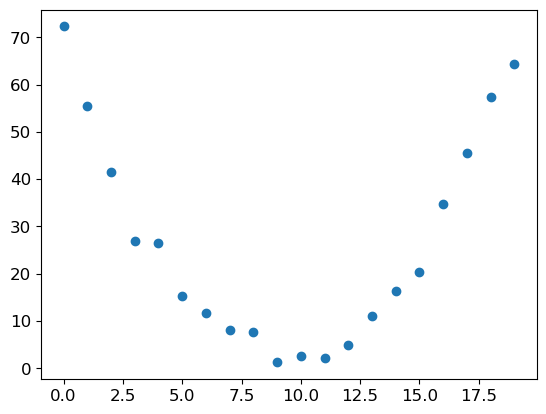

In [86]:
speed = torch.randn(20)*3 + 0.75*(time-9.5)**2 + 1  # speed are some values for speed that were supposedly measured every 20s
#speed
plt.scatter(time,speed);                            # they are recorded data, target data 

We've **added a bit of random noise**, since measuring things manually isn't precise.  
This means it's not that easy to answer the question: **what was the roller coaster's speed?**  
**Using SGD we can try to find a function that matches our observations**.  
We can't consider every possible function, so let's use a **guess that it will be quadratic**;  
i.e., a function of the form **`a*(time**2)+(b*time)+c`**.    

We want to distinguish clearly between  
the **function's input** (<u>the time</u> when we are measuring the coaster's speed)  
and **its parameters** (<u>the values that define *which* quadratic we're trying</u>).  
So, let's **collect the parameters in one argument and thus separate the input, `t`, and the parameters, `params`**, in the function's signature: 

In [87]:
'''
we want to create a function that estimates at any time what is the speed of the rolercoaster
so we start by guessing what function it might be
so we guess that it's a quadratic function 

so let's create it using the albert samuel technique, machine learning technique
it's going to take an input, which is a time
and it's going to take some parameters, a,b,c 
so in python you can split out a list or a collection into its components (a,b,c=params)
so we're not trying to find any function in the world, but a quadratic by finding an a,b and c
so arthur samuel technique for doing this is to next come up with a loss function
come up with a measurement of how good we are
'''

def f(t, params):                     # f is a function that aims to match the points above; we guess it's quadratic
    a,b,c = params                    # input is time and parameters are a,b,c
    return a*(t**2) + (b*t) + c       

In other words, we've restricted the problem of finding the best imaginable function that fits the data, 
to **finding the best *quadratic* function**.  
This greatly simplifies the problem, since every quadratic function is fully defined by the three parameters `a`, `b`, and `c`.  
Thus, **to find the best quadratic function, we only need to find the best values for `a`, `b`, and `c`**.  

If we can solve this problem for the three parameters of a quadratic function,  
we'll be able to **apply the same approach for other, more complex functions with more parameters — such as a neural net**.  
Let's find the parameters for `f` first, and then we'll come back and do the same thing for the MNIST dataset with a neural net.  

**We need to define first what we mean by "best"**.  
We define this precisely by **choosing a *loss function***,   
**which will return a value based on a prediction and a target,**  
where **lower values** of the function correspond to **"better" predictions**.   
It is important for **loss functions to return _lower_ values when predictions are more accurate**,  
as the SGD procedure we defined earlier will try to _minimize_ this loss.  
**For continuous data, it's common to use *mean squared error*:**  

In [88]:
'''
so if we've got some predictions that come out of our function and the targets which are these actual values (blue dots from the plot)
then we could just do the mse
now we need to go through our 7 step process


'''
def mse(preds, targets): return ((preds-targets)**2).mean()  # the loss function is MSE between predictions and targets

Now, let's work through our 7 step process.

#### Step 1: Initialize the parameters

First, **we initialize the parameters to random values**,  
and tell PyTorch that we want to **track their gradients**, using `requires_grad_`:

In [89]:
'''
we want to come up with a set of parameters a,b and c to random values
we're going to be adjusting them, so tell pytorch that we want the gradients
'''
params = torch.randn(3).requires_grad_()  # params are the weights for the quadratic function we want to find (a,b,c)

In [90]:
'''
I'm going to save these away to check them later
'''
#hide
orig_params = params.clone()

#### Step 2: Calculate the predictions

Next, we **calculate the predictions**:

In [91]:
'''
calculate the prediction using function f
'''
preds = f(time, params)  # f is quadratic with random parameters

Let's create **a little function to see how close our predictions are to our targets**, and take a look:

In [92]:
'''
and now create a function that plots how good are our predictions
here's a function that prints in red our predictions and in blue our targets
that looks pretty terible
'''
def show_preds(preds, ax=None):
    if ax is None: ax=plt.subplots()[1]
    ax.scatter(time, speed)                      # target data
    ax.scatter(time, to_np(preds), color='red')  # prediction data
    ax.set_ylim(-300,100)

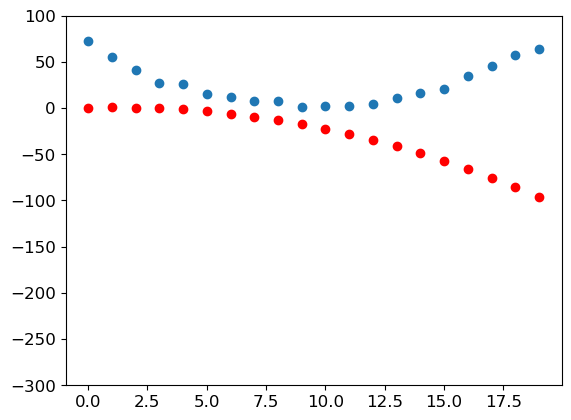

In [93]:
show_preds(preds)  # show predictions (red) with 1st choice of random parameters (params)

**This doesn't look very close** —  
our random parameters suggest that the roller coaster will end up **going backwards**,  
since we have **negative speeds!**

#### Step 3: Calculate the loss

We **calculate the loss** as follows:

In [94]:
'''
so let's calculate the loss, using the mse function we wrote
so now we want to improve this
'''
loss = mse(preds, speed) # preds are predictions with random parameters and speed are recorded data
loss

tensor(4990.9258, grad_fn=<MeanBackward0>)

Our goal is now to **improve** this.  
To do that, we'll need to **know the gradients.**

#### Step 4: Calculate the gradients

The next step is to **calculate the gradients**.  
In other words, **calculate an approximation of how the parameters need to change**:

In [95]:
'''
calculate the gradients using the 2 steps
each of our parameter has a gradient that's negative
'''
loss.backward()  # backward() means calculate_gradients(); # calculate gradients by derivating the loss function; find each gradient by derivating each ax**2 and keeping the rest as a constant
params.grad      # gradients are "attached" to params because it shows in which direction to change the params a,b,c  
                 # -73k,-5k,-0,3k

tensor([-22116.9102,  -1406.4412,   -112.9858])

In [96]:
'''
let's pick a learning rate of 10 to the -5  
'''
params.grad * 1e-5  # here shows what the step will be equal to = gradients * learning rate

tensor([-0.2212, -0.0141, -0.0011])

**We can use these gradients to improve our parameters.**  
We'll need to **pick a learning rate** (we'll discuss how to do that in practice in the next chapter; for now we'll just use 1e-5, or **0.00001**):

In [97]:
params  # these are the parameters before being adjusted with the learning rate

tensor([-0.3087,  0.8158,  0.1809], requires_grad=True)

#### Step 5: Step the weights. 

Now we need to **update the parameters based on the gradients we just calculated:**

In [98]:
'''
and step the weights
step is -= learning rate * gradient
there's a wonderful trick here, which I've called .data
there reason I've called .data is because it's a special attribute in pytorch, which if you use it, then the gradient is not calculated
and we don't want the gradient to be calculated of the actual step we're doing - me: here, in lr*grad we don't want to call .grad, so that's why add .data
we only want the gradient to be calculated of our function f
all right, so when we step the weights we have to use this special .data attribute (params.data in left side of the =)
after we do that delete the gradients what we already had and let's see if loss improved

'''
# w -=gradient(w)*lr
# adjusts the parameter in the direction of the slope (gradient)
# increasing the parameter when the slope (gradient) is negative and decreasing the parameter when the slope is positive
lr = 1e-5
params.data -= lr * params.grad.data  # how to change our parameters based on the values of the gradients	                            
params.grad = None                    # multiplying the gradient by some small number, called the learning rate (LR)

> a: Understanding this bit depends on remembering recent history.   
To **calculate the gradients** we call `backward` on the **`loss`**.  
But this `loss` was itself calculated by **`mse`**,  
which in turn took **`preds`** as an input,  
which was calculated using **`f`** taking as an input **`params`**,  
which was the object on which we originally called **`requires_grad_`**  
— which is the original call that now allows us to call `backward` on `loss`.  
This **chain of function calls** represents the mathematical composition of functions,  
which **enables PyTorch** to use calculus's chain rule under the hood to **calculate these gradients.**  

Let's see if **the loss has improved:**

In [99]:
'''
the loss before was 25823 and now is 5400
and the plot has gone from something that goes down to -300 to something that looks much better
'''
preds = f(time,params)  # new predictions based on quadratic f with new parameters
mse(preds, speed)       # new loss

tensor(1466.9171, grad_fn=<MeanBackward0>)

And take a look at **the plot:**

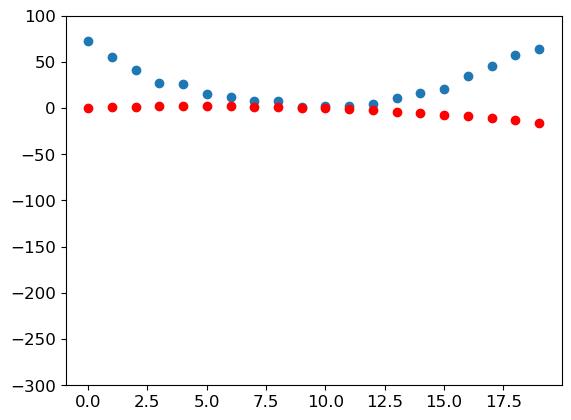

In [100]:
show_preds(preds)

We need to repeat this a few times, so we'll create **a function to apply one step:**  

In [101]:
def apply_step(params, prn=True):
    preds = f(time, params)
    loss = mse(preds, speed)
    loss.backward()
    params.data -= lr * params.grad.data
    params.grad = None
    if prn: print(loss.item())
    return preds

#### Step 6: Repeat the process 

Now we **iterate**.  
By looping and performing many improvements, we hope to reach a good result:

In [102]:
'''
put those steps in a function and repeat it 10 times
and the loss is getting better and better
'''
for i in range(10): apply_step(params)

1466.9171142578125
800.063232421875
673.8706665039062
649.9879150390625
645.465087890625
644.6058959960938
644.4398193359375
644.4051513671875
644.3951416015625
644.3899536132812


In [103]:
#hide
params = orig_params.detach().requires_grad_() 

**The loss is going down**, just as we hoped!  
But looking only at these loss numbers disguises the fact that each **iteration represents an entirely different quadratic function being tried**,  
on the way to finding the best possible quadratic function.  
We can see this process visually if, instead of printing out the loss function, **we plot the function at every step.**  
Then we can see how **the shape is approaching the best possible quadratic function for our data:**

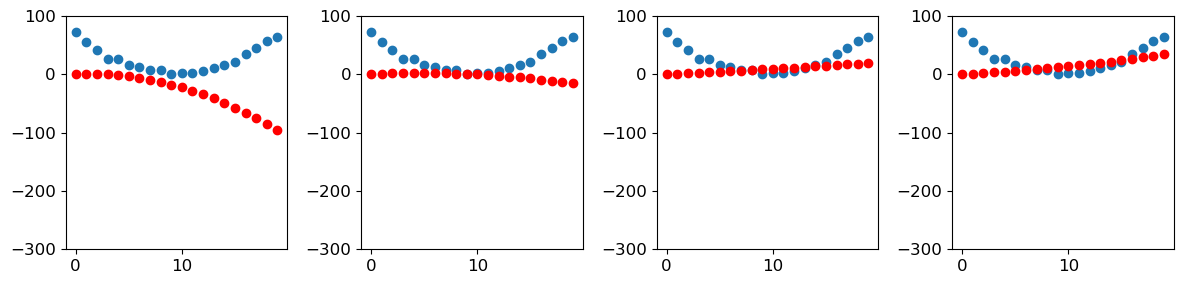

In [104]:
'''
and we can actually look at it getting better and better
so we have a technique, this is the arthur samuel technique
for finding a set of parameters that continuously improves 
by getting feedback from the result of measuring some loss fuction
so that was kind of the key step  
this is the gradient descent method
'''
_,axs = plt.subplots(1,4,figsize=(12,3))     
for ax in axs: show_preds(apply_step(params, False), ax)   
plt.tight_layout()   

#### Step 7: stop

We just decided to stop after 10 epochs arbitrarily.  
In practice, **we would watch the training and validation losses and our metrics to decide when to stop**, as we've discussed.

### Summarizing Gradient Descent

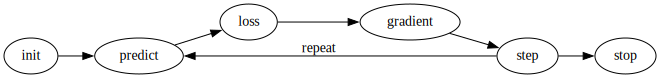

In [105]:
#hide_input
#id gradient_descent
#caption The gradient descent process
#alt Graph showing the steps for Gradient Descent
gv('''
init->predict->loss->gradient->step->stop
step->predict[label=repeat]
''')

To summarize,  
at the beginning, **the weights of our model can be random (training *from scratch*)**    
**or come from a pretrained model (*transfer learning*).**    
In the first case, the output we will get from our inputs won't have anything to do with what we want,  
and even in the second case, it's very likely the pretrained model won't be very good at the specific task we are targeting.  
**So the model will need to *learn* better weights.**  

**We begin by comparing the outputs the model gives us with our targets**  
(we have labeled data, so we know what result the model should give) **using a *loss function*,**  
**which returns a number that we want to make as low as possible by improving our weights.**  
To do this, **we take a few data items (such as images) from the training set and feed them to our model.  
We compare the corresponding targets using our loss function,  
and the score we get tells us how wrong our predictions were.**    
We then **change the weights a little bit** to make it slightly better.   

To find **how to change the weights to make the loss a bit better, we use calculus to calculate the *gradients*.**    
(Actually, we let PyTorch do it for us!)   
Let's consider an **analogy**.  
Imagine you are lost in the mountains with your **car parked at the lowest point.**  
To find your way back to it, you might wander in a random direction, but that probably wouldn't help much.  
Since you know your vehicle is at the lowest point, you would be better off going downhill.  
**By always taking a step in the direction of the steepest downward slope, you should eventually arrive at your destination.**  
**We use the magnitude of the gradient (i.e., the steepness of the slope) to tell us how big a step to take;**  
specifically, we multiply the gradient by a number we choose called the ***learning rate*** to decide on the step size.  
We then ***iterate*** until we have reached the lowest point, which will be our parking lot,  
then we can ***stop***.

All of that we just saw can be transposed directly to the MNIST dataset, except for the loss function.  
Let's now see how we can **define a good training objective.** 

## The MNIST Loss Function

We already have our **independent variables `x`—these are the images themselves.**  
We'll **concatenate them all into a single tensor,**  
and also change them from **a list of matrices (a rank-3 tensor) to a list of vectors (a rank-2 tensor).**  
We can do this using **`view`, which is a PyTorch method that changes the shape of a tensor without changing its contents.**  
`-1` is a special parameter to `view` that means **"make this axis as big as necessary to fit all the data":**  

In [106]:
'''
so now let's apply this to MNIST
so for MNIST we want to use this exact technique and there's nothing extra that we have to do
except on thing, we need a LOSS function
and the metric that we've been using is the error rate, or the accuracy 
    (the accuracy = how many of the predictions are true in the validation set
    using the mnist_distance that calculates the overall distance between an the validation set and an ideal 3/7)
accuracy = it's like how often are we correct 
and that's the thing we're actually trying to make good, our metric
but we've got a very serious problem, 
which is we need to calculate the gradient to figure out how we should change our parameters
and the gradient is the slope, or the steepness, which is rise / run
it's (y_new-y_old) / (x_new-x_old)  -->> on the loss graph
the gradient is actually defined when x_new is very, very close to x_old, 
meaning their difference is very small (because the derivative it's the tangent)
but think about accuracy: if I change a parameter by a tiny tiny amount, the accuracy might not change at all
(it's an horizontal line and it's slope in that x_new point is 0)
because there might not be any 3 that we now predict as a 7 or any 7 that we now predict as a 3
because we change the parameter by such a small amount
so it's certain that the gradient is 0 in many places, 
and that means our parameters aren't going to change at all
because learning rate * gradient is still 0 when the gradient is 0 for any learning rate
so this is why the loss function and the metric are not always the same thing
we can't use a metric as our loss if that metric has a gradient of zero
so we need something different
we need to find something that is pretty similar to the accuracy 
in that like as the accuracy gets better this ideal function we want gets better as well
but it should not have a gradient of 0

so let's think about that function
suppose we had 3 images
actually we will stop
we understand GD
we know how to do it with a simple loss function 



lesson 4 2020
deep into the weeds of what exactly is going on when we are training a neural network
and we started looking at this in the previous lesson, at SGD

we were looking at what Arthur Samuel said:
automatic means of testing the effectivenes of any current weight/paramenter assignment in terms of actual performance
and provide a mechanism for altering the weight assignment so as to maximize that performance
so we could make that entirely automatic 
and a machine so programmed would learn from its experience

our initial attempt on MNIST data set was not based on that
we didn't have any parameters 

lesson 4 2020
now let's use this to create our MNIST 3 and 7 model
and so to create a model we're going to need to create something that we can pass into a function like
this one: def pr_eight(x,w) = (x*w).sum()
so we need some pixels that are all lined up and some parameters that are all lined up
and then we're going to sum them up
so our axis/x's are going to be pixels and so in this case,
because we're just going to multiply each pixel by a parameter and add them up,
the effect that the're laid out in a grid is not important so let's reshape those grids
and turn them into vectors
the way we reshape things in pytorch is by using the view method
the view method you can pass to it how large you want each dimension to be
in this case, we want the number of columns to be equal to the total number of pixels in each picture, which is 28*28=784
and then the number of rows will be however many rows there are in the data
(me: so each picture now occupies a row of 784 columns or 784 numbers)
(in total are 12396 3s and 7s so there are that many rows)
so if you use -1 when you call view, that means as many there are in the data
so this will create something of the same, with the same total number of elements that we had before
so we can grab all our 3, we can concatenate them with torch cat with all of our 7s
and then reshape that into a matrix, where each row is one image
with all of the rows and columns of an image all lined up in a single vector
so that's our x.
'''

#train_test = torch.cat([stacked_threes, stacked_sevens])
#train_test

"\nso now let's apply this to MNIST\nso for MNIST we want to use this exact technique and there's nothing extra that we have to do\nexcept on thing, we need a LOSS function\nand the metric that we've been using is the error rate, or the accuracy \n    (the accuracy = how many of the predictions are true in the validation set\n    using the mnist_distance that calculates the overall distance between an the validation set and an ideal 3/7)\naccuracy = it's like how often are we correct \nand that's the thing we're actually trying to make good, our metric\nbut we've got a very serious problem, \nwhich is we need to calculate the gradient to figure out how we should change our parameters\nand the gradient is the slope, or the steepness, which is rise / run\nit's (y_new-y_old) / (x_new-x_old)  -->> on the loss graph\nthe gradient is actually defined when x_new is very, very close to x_old, \nmeaning their difference is very small (because the derivative it's the tangent)\nbut think about ac

In [107]:
train_x = torch.cat([stacked_threes, stacked_sevens]).view(-1, 28*28)  
# cat puts 3 above 7 because default axis is 0, the vertical axis
# view(-1,28*28) means fix one axis to 28*28 and one picture is now 784 columns/numbers
# and the -1 means to adapt so it can fit all images, the sum of 3s + 7s
# so this is a matrix now

We need a **label for each image.**  
We'll use `1` for 3s and `0` for 7s:

In [108]:
# test only
#train_test = tensor([1]*len(threes) + [0]*len(sevens))
#train_test, train_test.shape

In [109]:
'''
then we're going to need labels, 1 for each of the 3s and a 0 for each of the 7s
so basically we're going to create an is_3 model (what??)
so that's going to create a vector, we actually need it to be a matrix in pytorch
so unsqueeze will and an additional unit dimension to whatever I've asked for
so here in position 1, 
so in other words, this is going to turn up from which is a vector of 12396 long 
into a matrix with 12396 rows and 1 column
'''
# create a tensor for labels
train_y = tensor([1]*len(threes) + [0]*len(sevens)).unsqueeze(1)  # puts them vertical
train_x.shape,train_y.shape

(torch.Size([12396, 784]), torch.Size([12396, 1]))

In [110]:
train_y  # added by me

tensor([[1],
        [1],
        [1],
        ...,
        [0],
        [0],
        [0]])

**A `Dataset` in PyTorch is required to return a tuple of `(x,y)` when indexed.**  
Python provides **a `zip` function which, when combined with `list`**, provides a simple way to get this functionality:

In [111]:
'''
now we're going to turn or x and y into a dataset
and a Dataset is a very specific concept in pytorch
it's something we can index into, using []
and when we do so, it's expected to return a tuple 
containing our independent variable (x) and a dependent variable (y)
for each particular row (0 in this case)

and so to do that we can use the python zip function, 
which takes one element of the train_x and combines/concatenates it with one element of train_y
and it does that again and again and again
and so then if we create a list of those it gives us a Dataset

it gives us a list which when we index into it, it's going to contain 1 image and 1 label
and so here you can see "y" there's my label
and "x" my image, but I won't print the whole thing, it's a 784 long vector

so that's a really important concept: Dataset, something you can index into, and get back a tuple
this is called destructuring a tuple: which means I'm taking the 2 parts of the tuple
and putthing the 1st part in one variable (x) and the 2nd part in the other variable
which is something we do a lot in python, it's pretty handy
'''

dset = list(zip(train_x,train_y))  # so a pytorch dataset needs to return a tuple (a fixed list)
x,y = dset[0]
x.shape,y

(torch.Size([784]), tensor([1]))

In [112]:
'''
repeat the same 3 steps for the validation set
so we've now got a training Dataset and a validation Dataset
'''
valid_x = torch.cat([valid_3_tens, valid_7_tens]).view(-1, 28*28)             # create the valid dataset
valid_y = tensor([1]*len(valid_3_tens) + [0]*len(valid_7_tens)).unsqueeze(1)
valid_dset = list(zip(valid_x,valid_y))

Now we need **an (initially random) weight for every pixel**  
(this is the ***initialize* step** in our seven-step process):

In [113]:
'''
so now we need to initialize our parameters
and we just do it randomly
here's a function that given some size (shape if you like)
we'll randomly initialize, using a normal random number distribution in pytorch
(hit shift+tab with cursor inside the size of rand(size) to see more details)
and it says in the details that's going to have a variance of 1
so I probably should not call this standard deviation (std=1), but variance

so multiply it by the variance to change it's variance to whatever is requested (in arguments at std=)
which will default to 1

and as we talked about when it comes to calculating our gradients
we have to tell pytorch which things we want gradients for
and the way we do that is requires_grad_
the underscore _ at the end is a special magic symbol 
which tells pytorch that we want this function to actually change the thing that is referring to
this will change this tensor, such that it requires gradience


'''
def init_params(size, std=1.0): 
    return (torch.randn(size)*std).requires_grad_()

In [114]:
'''
here's some weights, so our weights are going to need to be 28*28=784 by 1 shape
28*28 because every pixel is going to need a weight
and then 1 because we're going to need to have that unit access to make it into a column
(me: to be vertical 784 weights, a single column)
so that's what pytorch expects 
so there's our weights
'''

weights = init_params((28*28,1))   # x are the pictures, which are 28*28 so the weights w should be the same

**The function `weights*pixels` won't be flexible enough**  
— it is always equal to 0 when the pixels are equal to 0 (i.e., its *intercept* is 0).  
You might remember from high school math that **the formula for a line is `y=w*x+b`; we still need the `b`.**  
**We'll initialize it to a random number too:**

In [115]:
'''
now just weights by pixels actually isn't going to be enough
because weights by pixels were always equal 0 when the pixels are equal to 0,
it has a 0 intercept
so we really want something where it's like w*x+b, a line
so the b we call the bias
so let's grab a single number for our bias =|> (1)

so I told you, there's a difference between parameters and weights

the weights from weights = init_params((28*28,1)) are the w in y=wx+b equation
and the bias is b in this equation
and the weights and bias together are the PARAMETERS  of the function
they're all the things that we're going to change, they're all the things that have gradients that we're going to update
'''
bias = init_params(1)

In neural networks, the `w` in the equation `y=w*x+b` is called the *weights*, and the `b` is called the *bias*.  
**Together, the weights and bias make up the *parameters*.**

> jargon: Parameters: The _weights_ and _biases_ of a model.  
> The weights are the `w` in the equation `w*x+b`, and the biases are the `b` in that equation.

**We can now calculate a prediction for one image:**

In [116]:
'''
we can now create and calculate predictions for one image 
so we can take an image such as the 1st one
and multiply by the weights only to transpose them 
to make them line up in terms of the rows and columns 
and add it up, 
and add the bias 
and there is a prediction

we want to do that for every image 
we could do that with a for loop and that would be really, really slow
it wouldn't run on the gpu and it wouldn't run in optimized c code
so we actually want to use always to do kind of like looping over pixels, looping over images
you always want to make sure you're doing that without a python loop
in this case doing this calculation for lots of rows and columns is the matrix multiplication operation
'''
(train_x[0]*weights.T).sum() + bias  # why? because a nn it's a linear function; and pr_eight is also multiplication + sum; here it adds a bias

tensor([1.4917], grad_fn=<AddBackward0>)

While we could use a Python `for` loop to calculate the prediction for each image, that would be very slow.  
Because Python loops don't run on the GPU, and because Python is a slow language for loops in general,  
**we need to represent as much of the computation in a model as possible using higher-level functions.**

In this case, there's an extremely convenient mathematical operation that calculates `w*x` for every row of a matrix—it's called ***matrix multiplication***.  
<<matmul>> shows what matrix multiplication looks like.

<img alt="Matrix multiplication" width="400" caption="Matrix multiplication" src="images/matmul2.svg" id="matmul"/>

This image shows two matrices, `A` and `B`, being multiplied together.  
Each item of the result, which we'll call `AB`, contains each item of its corresponding row of `A` multiplied by each item of its corresponding column of `B`, added together.  
For instance, **row 1, column 2 (the yellow dot with a red border) is calculated as $a_{1,1} * b_{1,2} + a_{1,2} * b_{2,2}$.**  
If you need a refresher on matrix multiplication, we suggest you take a look at the [Intro to Matrix Multiplication](https://youtu.be/kT4Mp9EdVqs) on *Khan Academy*,  
since this is the most important mathematical operation in deep learning.  

**In Python, matrix multiplication is represented with the `@` operator.**    
Let's try it:

In [117]:
'''
1st prediction is 20.2336 as above with train_x[0]
so matrix multiplication gives us an optimized way to do these simple linear function
wehreas we want as many rows and columns as we want
so this is one of the 2 fundamental equations of any neural network
some rows and columns of data multiply some weights add some bias 
and the 2nd one is an activation function

so these are some predictions from our randomly initialized model
'''
def linear1(xb): return xb@weights + bias
preds = linear1(train_x)
preds

tensor([[ 1.4917],
        [ 8.0730],
        [13.7015],
        ...,
        [-4.6291],
        [13.3116],
        [-3.6772]], grad_fn=<AddBackward0>)

The first element is the same as we calculated before, as we'd expect.  
**This equation, `batch@weights + bias`, is one of the two fundamental equations of any neural network**  
(the other one is the ***activation function***, which we'll see in a moment).

Let's check our **accuracy**.  
**To decide if an output represents a 3 or a 7, we can just check whether it's greater than 0.0,**  
so our accuracy for each item can be calculated (using broadcasting, so no loops!) with:

In [118]:
'''
so we can check how good our model is
and so to do that we can decide that anything greater than 0 we will call a 3
and anything less than 0 we will call a 7
so preds greater than 0 tells us whether or not something is predicted to be a 3 or not
then turn that into a float, so rather than true and false, make it 1 and 0, 
because it's what our training set contains (train_y)

and check with our thresholded predictions are equal to our training set 
and this will return true every time a row is correctly predicted and false otherwise
'''
corrects = (preds>0.0).float() == train_y  # compare the predictions with train_y
                                           # train_y is 1(3s) and 0(7s)
                                           # preds>0 means 1; if it's equal with 1 in train_y then it's a 3
corrects

tensor([[ True],
        [ True],
        [ True],
        ...,
        [ True],
        [False],
        [ True]])

In [119]:
'''
so if we take all these trues and falses and turn them into floasts, that'll be 1s and 0s
and then take their mean it's 0.49
so not surprisingly our randomly initialized model is right about half the time at predicting 3s from 7s
I added one more method here, which is .item() 
without .item() this will return a tensor, it's a rank 0 tensor, it has no rows, no columns
it just it's number on its own, but I actually wanted to unwrap it to create a normal python scalar
mainly just because I wanted to easily see the decimal places 
and the reason for that is I want to show you how we're going to calculate the derivative on the accuracy
by changing a parameter a tiny bit
'''
corrects.float().mean().item()

0.5893836617469788

Now let's see what **the change in accuracy is for a small change in one of the weights**    
(note that we have to ask PyTorch not to calculate gradients as we do this, which is what `with torch.no_grad()` is doing here):

In [120]:
'''
so let's take one parameter, which will be w[0] and multiply it with 1.0001
and so that's going to make it a little bit bigger
and then if I calculate how the accuracy changes based on the change in that weight
that will be the gradient of the accuracy with respect to that parameter
'''

with torch.no_grad(): weights[0] *= 1.0001  

In [121]:
'''
so I can do that by calculating my new set of predictions and then I can threshold them
and then I can check whether they're equal to the training set and then take the mean
and I get back exactly the same number 
so remember that gradient is equal to rise/run 

the change in y, so y_new-y_old (that's the accuracy, the y function = wx+b)
which is which is 0.4912 - 0.4912, which is 0
divided by this change in x (1.0001) 
will give us 0
so at this point we have a problem: our derivative is 0 so we have 0 gradients:
which means our step will be 0
which means our prediction will be unchanged

ok, so we have problem
our problem is that our gradient is zero and with a gradient of 0
we can't take a step and we can't get better predictions
and so intuitively speaking, the reason that our gradient is 0
is because when we change a single pixel by a tiny bit
we might not ever in any way change an actual prediction to change from predicting a 3 to a 7
or viceversa
because we have this threshold (preds>0.0)

so in other words, our accuracy loss function here is very bumpy
it's like a flat step, flat step, flat step
so it's got this 9 gradient all over the place
so what we need to do it use something other than accuracy as our loss function

so let's try and create a new function 
and what this new function is going to do, it's going to give us a better value
kind of in much the same way that accuracy gives a better value
so this is the loss, and remember, the small loss is better
so to give us a lower loss, when the accuracy is better 
but it won't have a zero gradient
it means that a slightly better prediction needs to have a slightly better loss (lower loss is better)
'''

preds = linear1(train_x)
((preds>0.0).float() == train_y).float().mean().item()  # same value, which means the y is constant 
                                                        # so the gradient/derivative is 0 = useless

0.5893836617469788

As we've seen, **we need gradients in order to improve our model using SGD,**  
and in order to calculate gradients we need some ***loss function* that represents how good our model is.**  
That is because the gradients are a measure of how that loss function changes with small tweaks to the weights.  

**So, we need to choose a loss function.**  
The obvious approach would be to use **accuracy**, which is our metric, as our loss function as well.  
In this case, we would calculate our prediction for each image, collect these values to calculate an overall accuracy,  
and then calculate **the gradients of each weight with respect to that overall accuracy.**

Unfortunately, we have a **significant technical problem here.**  
**The gradient of a function is its *slope***, or its steepness, which can be defined as ***rise over run***       
— that is, how much the value of the function goes up or down, divided by how much we changed the input.  
We can write this in mathematically as: **`(y_new - y_old) / (x_new - x_old)`**.  
This gives us **a good approximation of the gradient when `x_new` is very similar to `x_old`**, meaning that their difference is very small.  
**But accuracy only changes at all when a prediction changes from a 3 to a 7, or vice versa.**  
The problem is that a small change in weights from `x_old` to `x_new` isn't likely to cause any prediction to change,    
so `(y_new - y_old)` will almost always be 0.   
In other words, **the gradient is 0 almost everywhere.**  

A very small change in the value of a weight will often not actually change the accuracy at all.  
This means **it is not useful to use accuracy as a loss function**   
— if we do, most of the time our gradients will actually be 0, and the model will not be able to learn from that number.  

> S: In mathematical terms, accuracy is a function that is constant almost everywhere (except at the threshold, 0.5),  
> so its derivative is nil almost everywhere (and infinity at the threshold).  
> This then gives gradients that are 0 or infinite, which are useless for updating the model.  

Instead, **we need a loss function which, when our weights result in slightly better predictions, gives us a slightly better loss.**  
So what does a "slightly better prediction" look like, exactly?  
Well, in this case, it means that **if the correct answer is a 3 the score is a little higher, or if the correct answer is a 7 the score is a little lower.**  

Let's write such a function now.  
What form does it take?  

**The loss function receives not the images themselves, but the predictions from the model.**  
Let's make **one argument, `prds`, of values between 0 and 1, where each value is the prediction that an image is a 3.**  
It is a vector (i.e., a rank-1 tensor), indexed over the images.  

**The purpose of the loss function is to measure the difference between predicted values and the true values — that is, the targets (aka labels).**  
**Let's make another argument, `trgts`, with values of 0 or 1 which tells whether an image actually is a 3 or not.**    
It is also a vector (i.e., another rank-1 tensor), indexed over the images.  

So, for instance, **suppose we had three images which we knew were a 3, a 7, and a 3.**    
**And suppose our model predicted:**  
    <u>with high confidence (`0.9`) that the first was a 3,</u>  
    <u>with slight confidence (`0.4`) that the second was a 7,</u>        
    <u>and with fair confidence (`0.2`), but incorrectly, that the last was a 7.</u>    
This would mean **our loss function would receive these values as its inputs:**  

In [122]:
# prds are received from the model (the model doesn't send images, but predictions)

In [123]:
'''
so let's have a look at an example
let's say our targets, our labels, of like that are 3
it's 3 images here: 1,0,1
and we've made some predictions from a neural net
and those predictions gave us 0.9,0.4,0.2

[after the next cell text, jumps back here:]
so you can see here, when the prediction is correct
in other words, it's a high number when the target is 1
and a low number when the target is 0
so the worst one is when we predicted 0.2
so we really thought that was a 0, but it's actually a one
[continuation to torch.where(trgts==1, 1-prds, prds)]
'''
trgts = tensor([1,0,1])            # true images:     3,          7,               3              (1 if it's a 3, and 0 if it's not a 3)
prds  = tensor([0.9, 0.4, 0.2])    # model predicts:  0.9 is 3    0.4 that is 7    0.2 that is 7  (incorrect)                                   
#prds  = tensor([1, 0, 1])
#prds  = 1-tensor([1, 0, 1])

**Here's a first try at a loss function that measures the distance between `predictions` and `targets`:**  

In [124]:
'''
so now consider this loss function
we're going to use torch.where, which is the same as this list comprehension
it's basically an if statement so it's going to say:
for where targets equals 1, we're going to return 1-predictions
and where is not 1 it will just be predictions
'''
# if it should be 1 (targets==1) then what is the distance from pred to 1 (1-pred)
# if it should be 0 (targets==0) then what is the distance from pred to 0 (pred)
def mnist_loss(predictions, targets):  
    return torch.where(targets==1, 1-predictions, predictions).mean()  # the loss is the mean of all these distances between predictions and targets


**We're using a new function, `torch.where(a,b,c)`.**  
This is the same as running the **list comprehension `[b[i] if a[i] else c[i] for i in range(len(a))]`,**  
except it works on tensors, at C/CUDA speed.  
In plain English, **this function will measure how distant each prediction is from 1 if it should be 1,      
and how distant it is from 0 if it should be 0,  
and then it will take the mean of all those distances.**  

> note: Read the Docs: It's important to learn about PyTorch functions like this,  
> because looping over tensors in Python performs at Python speed, not C/CUDA speed!  
> Try running **`help(torch.where)`** now to read the docs for this function, or, better still, look it up on the PyTorch documentation site.  

In [125]:
#help(torch.where)

**Let's try it on our `prds` and `trgts`:**

In [126]:
'''
so we ended up with 0.8 here because it is 1-prediction (1-0.2=0.8)
'''
torch.where(trgts==1, 1-prds, prds)  # if targets equals 1, replace with 1-prds, otherwise replace with prds: 1-0.9, 0.4, 1-0.8

tensor([0.1000, 0.4000, 0.8000])

**You can see that this function returns a lower number when:    
predictions are more accurate,  
when accurate predictions are more confident (higher absolute values), (prds=0.9 and trgts=1 -> returns 0.1)    
and when inaccurate predictions are less confident.**    
In PyTorch, we always assume that a lower value of a loss function is better.  
**Since we need a scalar for the final loss, `mnist_loss` takes the mean of the previous tensor:**  

In [127]:
'''
so we can then take the mean of all of these to calculate a loss
so if you think about it, this loss will be the smallest if the predictions are exactly right
so if we did predictions that are identical to the targes ([1,0,1]) then torch.where(trgts==1, 1-prds, prds) will be [0,0,0] ~ loss is 0, the ideal
if they were exactly wrong (prds  = 1-tensor([1, 0, 1])) then torch.where/loss is [1,1,1]

so the loss will be better (smaller) when the predictions are closer to the targets
so here we can now take the mean and when we do, we get here 0.433
'''
mnist_loss(prds,trgts)

tensor(0.4333)

For instance, if we change our prediction for **the one "false" target from `0.2` to `0.8` the loss will go down**,  
indicating that this is **a better prediction:**  
me: why 0.8 for an incorrect 7 is better than 0.2 for an incorrect 7  
because 0.9 is closer to 1 than to 0 so it predicts a 1, which is a 3  
and 0.2 is closer to 0 than to 1, so it predicts a 0, which is a 7 (which is incorrect)  
and 0.8 is closer to 1, so it predicts 1, which is a 3 (which is correct)  

In [128]:
'''
let's say we change this last bad one in accurate prediction from 0.2 to 0.8 
and the loss gets better, from 0.43 to 0.23 but this is just this function torch.where().mean()
this is pretty good, a loss function which pretty closely tracks accuracy
if the accuracy is better the loss will be smaller
but also it doesn't have these 0 gradients because every time we change the prediction the loss changes
because the prediction is literally harder?? the loss
but this is going to work when predictions are between 0 and 1
otherwise this 1-prediction thing is going to look a bit funny
we should try and find a way to ensure that the predictions are always between 0 and 1
and it makes more intuitively sense because we want to thing at these as probabilities [0.9, 0.4, 0.8]
or at least nicely scaled numbers 
'''
mnist_loss(tensor([0.9, 0.4, 0.8]),trgts)

tensor(0.2333)

**One problem with `mnist_loss` as currently defined is that it assumes that predictions are always between 0 and 1.**  
**We need to ensure, then, that this is actually the case!**  
As it happens, there is a function that does exactly that — let's take a look.

### Sigmoid

**The `sigmoid` function always outputs a number between 0 and 1.**  
It's defined as follows:

In [129]:
'''
so we need some function that can take our big numbers in preds tensor (cell 99) (20, 15, 18 etc)
and turn them all into numbers between 0 and 1
and it happens that we have exactly the right function, 
the sigmoid: if you pass in a really small number you get a number very close to 0
if you pass in a big number you get a number very close to 1
it never gets past 1 and it never goes smaller than 0
and it's kind of like this smooth curve between
and in the middle it looks a lot like the y = x line
this is the definition of the sigmoid function

what is exponential? is e to the power of something
'''
def sigmoid(x): 
    return 1/(1+torch.exp(-x)) # 1/(1+e^-x)

In [130]:
'''
e is just a number like pi
'''
math.e**2

7.3890560989306495

In [131]:
torch.exp(tensor(2))  # the same numbers as the cell above

tensor(7.3891)

Pytorch defines an accelerated version for us, so we don’t really need our own.  
This is an important function in deep learning, since we often want to **ensure values are between 0 and 1.**    
This is what it looks like:

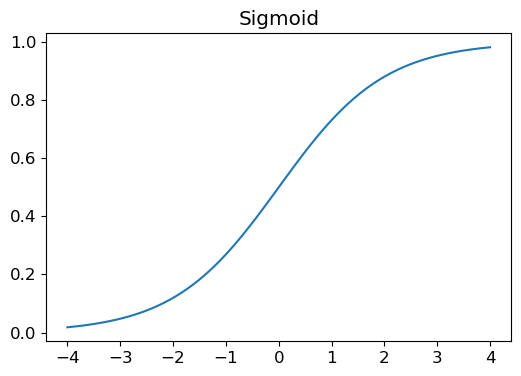

In [132]:
plot_function(torch.sigmoid, title='Sigmoid', min=-4, max=4)

As you can see, it takes any input value, positive or negative, and smooshes it onto an output value between 0 and 1.  
**It's also a smooth curve that only goes up, which makes it easier for SGD to find meaningful gradients.** 

**Let's update `mnist_loss` to first apply `sigmoid` to the inputs:**

In [133]:
'''
so we can change mnist_loss to be exactly the same as it was before but first we can make everything into sigmoid first
and then use torch.where

so that is a loss function that has all the properties we want
it will not have those nasty 0 gradients and we ensure that the input  to the where() is between 0 and 1  
so the reason we did this is because our accuracy was kind of what we really cared about to be a good accuracy    
we can't use it to get our gradients, just to create our steps, to improve our parameters
so we can change our accuracy to another function that is better when the accuracy is better
but also it does not have these 0 gradients
and so we can see now where, why we have a metric and a loss 
the metric is the thing we actually care about
the loss is the thing that's similar to what we care about
but has a nicely behaved gradient
sometimes, the thing you care about, your metric, does have a nicely defined gradient
and you can use it directly as a loss
for example, we often use mean squared error but for classification unfortunately not
'''
def mnist_loss(predictions, targets):
    predictions = predictions.sigmoid()
    return torch.where(targets==1, 1-predictions, predictions).mean()

Now we can be confident our loss function will work, even if the predictions are not between 0 and 1.  
**All that is required is that a higher prediction corresponds to higher confidence an image is a 3.**  

Having defined a loss function, now is a good moment to recapitulate why we did this.  
After all, we already had a metric, which was **overall accuracy.**  
**So why did we define a loss?**  

The key difference is that the metric is to drive human understanding and **the loss is to drive automated learning.**    
**To drive automated learning, the loss must be a function that has a meaningful derivative.**  
It can't have big flat sections and large jumps, but instead **must be reasonably smooth.**   
This is why we designed a loss function that would respond to small changes in confidence level.  
This requirement means that sometimes it does not really reflect exactly what we are trying to achieve,  
**but is rather a compromise between our real goal and a function that can be optimized using its gradient.**  
**The loss** function is calculated for **each item** in our dataset,  
and then at the end of an epoch the loss values are all averaged and **the overall mean is reported for the epoch.**

**Metrics, on the other hand, are the numbers that we really care about.**  
These are the values that are **printed at the end of each epoch that tell us how our model is really doing.**  
It is important that we learn to **focus on these metrics, rather than the loss, when judging the performance of a model.**

### SGD and Mini-Batches

Now that we have a loss function that is suitable for driving SGD,  
we can consider some of the details involved in **the next phase of the learning process,**  
which is to **change or update the weights based on the gradients.**  
**This is called an *optimization step***.

In order to take **an optimization step** we need to **calculate the loss over one or more data items.**  
How many should we use? We could calculate it for **the whole dataset, and take the average,**  
or we could calculate it for **a single data item.**  
But neither of these is ideal.   
Calculating it for the whole dataset would take **a very long time.**  
Calculating it for a single item would not use much information, so it would result in **a very imprecise and unstable gradient.**  
That is, you'd be going to the trouble of updating the weights,  
but taking into account only how that would improve the model's performance on that single item.  

So instead we take a **compromise** between the two: we calculate **the average loss for a few data items at a time.**  
**This is called a *mini-batch*.**  
The number of data items in the mini-batch is called the ***batch size***.  
**A larger batch size** means that you will get a **more accurate and stable estimate** of your dataset's gradients from the loss function,  
but it **will take longer**, and you will process fewer mini-batches per epoch.  
Choosing a good batch size is one of the decisions you need to make as a deep learning practitioner to train your model quickly and accurately.  
We will talk about how to make this choice throughout this book.  

Another good reason for using **mini-batches** rather than calculating the gradient on individual data items is that,  
in practice, we nearly always do our training on **an accelerator such as a GPU**.  
These accelerators only perform well if they have **lots of work to do at a time,**  
so it's helpful if we can give them lots of data items to work on.  
Using mini-batches is one of the best ways to do this.  
However, if you give them too much data to work on at once, they run out of memory — making GPUs happy is also tricky!  

As we saw in our discussion of data augmentation in <<chapter_production>>,  
**we get better generalization if we can vary things during training.**  
One simple and effective thing **we can vary is what data items we put in each mini-batch.**  
Rather than simply enumerating our dataset in order for every epoch,  
instead what we normally do is **randomly shuffle it on every epoch, before we create mini-batches.**    
**PyTorch and fastai provide a class that will do the shuffling and mini-batch collation for you, called `DataLoader`.**  

**A `DataLoader` can take any Python collection and turn it into an iterator over mini-batches, like so:**

In [134]:
'''
so we need to now use this to update the parameters
so there's a couple of ways we could do this
one would be to loop through every image
calculate a prediction for that image 
and then calculate a loss
and then do a step and then step the parameters
and then do that again for the next image, and the next image
that's going to be really slow because we're doing a single step for a single image
so that would mean an epoch would take quite a while
we could go much faster by doing every single image in the data set
so a big matrix multiplication it can all be paralelized on the GPU
and then so we can do a step based on the gradients looking at the entire dataset
but now that's going to be like a lot of work to just update the weights once
and remember sometimes our datasets have millions or tens of millions of items
so that's probably a bad idea too
so why not compromised?
let's grab a few data items at a time to calculate our loss and our step
if we grab a few data items at a time those 2 data items are called a mini batch
and a mini-batch just means a few pieces of data
and so the size of your mini batch is called the batch size
so the bigger the batch size, the closer you get to the full size of your dataset
the longer it's going to take to calculate a single set of losses, a single step
but the more accurate it's going to be, it's going to be like, 
the gradients are going to be much closer to the true data set gradients
and then the smaller the batch size, the faster each step we'll be able to do
but those steps will represent a smaller number of items
so they won't be such accurate approximation of the real gradient of the whole dataset

so how do we ask for a few items at a time?
it turns out that pytorch and fastai provides something to do that for you
you can pass in any dataset to do this class called DataLoader
and it will grab a few items from that dataset at a time
how many: batch_size
so it will grab a few items at the time, until it's grabbed all of them

so here, let's create a collection (coll) that just contains all the numbers from 0 to 14
let's pass that into a dataloader with a batch size of 5
and then, that's going to be something called an iterator, in python
it's something that you can ask for one more thing from an iterator
if you pass an iterator to list in python, it returns all the things from the iterator
so here are my three mini-batches (3 rows of 5) from 0 to 14, 5 at the time, appear in random order because suffle=true
normally in the training set we ask for things to be suffled, so it gives us a little bit of more randomization
more randomization is good, because it makes it harder for it to learn what the dataset looks like
so that's how our DataLoader is created

now remember though, that our datasets actually return tuples, and here I've just got single ints

'''
coll = range(15)
dl = DataLoader(coll, batch_size=5, shuffle=True)
list(dl)

[tensor([ 3, 12,  8, 10,  2]),
 tensor([ 9,  4,  7, 14,  5]),
 tensor([ 1, 13,  0,  6, 11])]

**For training a model, we don't just want any Python collection,  
but a collection containing independent and dependent variables (that is, the inputs and targets of the model).**  
**A collection that contains tuples of independent and dependent variables is known in PyTorch as a `Dataset`.**  
Here's an example of an **extremely simple `Dataset`:**    

In [135]:
'''
so let's actually create a tuple, so if we enumerate all the letters of english
then that means that returns (0, 'a'),(1, 'b') etc
let's make that our dataset 
'''

ds = L(enumerate(string.ascii_lowercase))
ds

(#26) [(0, 'a'),(1, 'b'),(2, 'c'),(3, 'd'),(4, 'e'),(5, 'f'),(6, 'g'),(7, 'h'),(8, 'i'),(9, 'j')...]

**When we pass a `Dataset` to a `DataLoader` we will get back mini-batches**  
which are themselves **tuples of tensors representing batches of independent and dependent variables:**

In [136]:
'''
so, if we pass that to a DataLoader with a batch size of 6, as you can see, 
it returns tuples containing 6 of the first things, and the associated 6 of the second things
so this is like our independent variable (numbers) and this is like our dependent variable (letters)
okay, so at the end the batch size weren't necessarily exactly divided nicely into the full size of the Dataset,
you might end up wiht a smaller batch
so basically then, we already have a Dataset remember, and so we could pass it to a DataLoader 

'''
dl = DataLoader(ds, batch_size=6, shuffle=True)  # 26 elements from 0 to 25
list(dl)

[(tensor([17, 18, 10, 22,  8, 14]), ('r', 's', 'k', 'w', 'i', 'o')),
 (tensor([20, 15,  9, 13, 21, 12]), ('u', 'p', 'j', 'n', 'v', 'm')),
 (tensor([ 7, 25,  6,  5, 11, 23]), ('h', 'z', 'g', 'f', 'l', 'x')),
 (tensor([ 1,  3,  0, 24, 19, 16]), ('b', 'd', 'a', 'y', 't', 'q')),
 (tensor([2, 4]), ('c', 'e'))]

We are now ready to write our first training loop for a model using SGD!

## Putting It All Together

In [137]:
'''
and then we can basically say this
an iterator in python is something that you can actually loop through
so when we say "for" in dataloader it's going to return a tuple
we can destructure it in the 1st bit, 2nd bit so that's going to be our x and y
we can calculate our predictions, our loss from the predictions and the targets
calculate our gradients (backward)
and we can update our parameters just like we did in our toy SGD example for the quadratic equation
'''

'\nand then we can basically say this\nan iterator in python is something that you can actually loop through\nso when we say "for" in dataloader it\'s going to return a tuple\nwe can destructure it in the 1st bit, 2nd bit so that\'s going to be our x and y\nwe can calculate our predictions, our loss from the predictions and the targets\ncalculate our gradients (backward)\nand we can update our parameters just like we did in our toy SGD example for the quadratic equation\n'



It's time to **implement the process we saw in <<gradient_descent>>.**  
In code, our process will be implemented something like this **for each epoch:**

```python
for x,y in dl:
    pred = model(x)
    loss = loss_func(pred, y)
    loss.backward()
    parameters -= parameters.grad * lr
```

First, let's **re-initialize our parameters:**

In [138]:
'''
so that's reinitialize our weights with the same 2 lines of code before
'''
weights = init_params((28*28,1))
bias = init_params(1)

**A `DataLoader` can be created from a `Dataset`:**

In [139]:
'''
create the data loader this time from our mnist dataset
and create a nice, big batch size
so we do plenty of work each time
and just to take a look, grab the 1st thing rom the dataloader
first is a fastai function which grabs the 1st thing from an iterator (dl)
it's useful to look at, kind of an arbitrary mini batch
so here's the shape we're going to have
the 1st mini batch is 256 rows of 784 long, 
that's 28 by 28 
so 256 flattened out images (xb), 
and 256 labels that are 1 column (yb), 0 or 1, depending on whether it's a 3 or a 7
 
'''
dl = DataLoader(dset, batch_size=256)
xb,yb = first(dl)  # first element of dl; 256 flattened out images and 256 labels that are 1 column
xb.shape,yb.shape

(torch.Size([256, 784]), torch.Size([256, 1]))

**We'll do the same for the validation set:**

In [140]:
'''
so here's out validation dataloader
'''
valid_dl = DataLoader(valid_dset, batch_size=256)

**Let's create a mini-batch of size 4 for testing:**

In [141]:
'''
so let's grab a batch here, testing
'''
batch = train_x[:4]
batch.shape

torch.Size([4, 784])

In [142]:
linear1??

Signature: linear1(xb)
Docstring: <no docstring>
Source:    def linear1(xb): return xb@weights + bias
File:      /tmp/ipykernel_2594/2527206448.py
Type:      function

In [143]:
'''
well, for our testing I'm going to just manually grab the first 4 things just so that we make sure everything lines up
pass it into that linear function, we created earlier
remember linear was just x batch @ weights (matrix multiply) plus bias
and that's going to give us 4 results
that's a prediction of each of those 4 images
'''
preds = linear1(batch)  # who is linear1? the model: def linear1(xb): return xb@weights + bias  // preds = linear1(train_x) - here 
preds

tensor([[ 2.0346],
        [ 3.7392],
        [15.1718],
        [ 7.5507]], grad_fn=<AddBackward0>)

**me: calculate the loss:**

In [144]:
'''
and so then we can calculate the loss using that loss function we just used
and let's just grab the fist 4 items of the training set (4 same as the preds)
'''
loss = mnist_loss(preds, train_y[:4])  # the loss between predictions and targets
loss

tensor(0.0348, grad_fn=<MeanBackward0>)

**Now we can calculate the gradients:**

In [145]:
'''
and now we can calculate the gradients of the training set
and so the gradients are 784 by 1, so it's a column where every weight as a gradient
it's what's the change in loss for a small change in that parameter 
and then the bias as a gradient, it's a single number, because the bias is just a single number
'''
loss.backward()
weights.grad.shape,weights.grad.mean(),bias.grad  # 784 gradients in a vertical tensor-1 ; their mean is the 2nd value ; bias gradient is the 3rd
#weights.grad

(torch.Size([784, 1]), tensor(-0.0045), tensor([-0.0314]))

**Let's put that all in a function:**

In [146]:
'''
so we can take those 3 steps and put it in a function
if you pass it an x batch, a y batch and some model 
then it's going to calculate the predictions, the loss, and do the backward step

'''
def calc_grad(xb, yb, model):  # all the above
    preds = model(xb)
    loss = mnist_loss(preds, yb)
    loss.backward()

**and test it:**

In [147]:
'''
and here we see
just to take a look, the mean of the weights gradient and the bias gradient
and there it is
'''
calc_grad(batch, train_y[:4], linear1)  # linear1 is the model
weights.grad.mean(),bias.grad

(tensor(-0.0090), tensor([-0.0627]))

**But look what happens if we call it twice:**

In [148]:
'''
if I call it the 2nd time, 
notice I haven't done any step here. these are exactly the same parameters
I get a different value, that's a concern
you would expect to get the same gradient every time you called it with the same data
why have the gradients changed?
that's because loss.backward doesn't just calculate the gradients 
it calculates the gradients and adds them to the existing gradients
the things in the .grad attribute of weights (weights.grad)
the reasons for that will come to later
what we need to do is to call grad.zero_()
so .zero returns a tensor containing 0s and remember _ does it in place, 
so that updates the weights.grad attribute, which is a tensor, to contain 0s
so now, if I do that, and call it again, I will get exactly the same number

'''
calc_grad(batch, train_y[:4], linear1)
weights.grad.mean(),bias.grad

(tensor(-0.0134), tensor([-0.0941]))

The gradients have **changed!**    
The reason for this is that **`loss.backward` actually *adds* the gradients of `loss` to any gradients that are currently stored.**    
**So, we have to set the current gradients to 0 first:**

In [149]:
weights.grad.zero_()  # all elements of tensor weights.grad set to 0
bias.grad.zero_();  # all elements of tensor bias.grad set to 0

> note: Inplace Operations: Methods in PyTorch whose names end in an underscore modify their objects _in place_.  
> For instance, **`bias.zero_()` sets all elements of the tensor `bias` to 0.**

**Our only remaining step is to update the weights and biases based on the gradient and learning rate.**  
When we do so, we have to **tell PyTorch not to take the gradient of this step too**  
— otherwise things will get very confusing when we try to compute the derivative at the next batch!  
**If we assign to the `data` attribute of a tensor then PyTorch will not take the gradient of that step.**  
Here's our basic **training loop for an epoch:**

In [150]:
'''
here's how you train one epoch with SGD:
loop through the DataLoader (for), grabbing the X batch and the y batch (xb,yb)
calculate the gradient (composed of: prediction, loss, backward)
go through each of the parameters (passed in) - 784 weights and 1 bias
and for each of those update the parameter to go minus equals gradient * learning rate (that's our GD step)
and then zero it out for the next time around the loop
I'm not saying p -= but p.data
and the reason for that is that, remember, pytorch keeps track of all of the calculations we do
so that it can calculate the gradient
well, I don't want to calculate the gradient in my gradient descent step
that's like not part of the model , right?
so .data is a special attribute in pytorch, where if you write to it, 
it tells pytorch not to update the gradients using that calculation

so this is your most basic, standard SGD loop
so the difference between stochastic GD and GD is that GD doesn't have this for loop that loops through each mini-batch
GD it does it on the whole dataset each time around
so train epoch or GD would simply not have the for loop,
but instead would calculate the gradient for the whole dataset and update the parameters based on the whole dataset
which we never really do in practice
we always use mini-batches of various sizes
'''
def train_epoch(model, lr, params):
    for xb,yb in dl:
        calc_grad(xb, yb, model)
        for p in params:
            p.data -= p.grad*lr  # If we assign to the `data` attribute of a tensor then PyTorch will not take the gradient of that step.
            p.grad.zero_()

We also want to **check how we're doing, by looking at the accuracy of the validation set.**  (how to calculate accuracy?)  
To decide if an output represents a 3 or a 7, we can just check whether it's greater than 0. (because a 3 is represented by 1?)   
**So our accuracy for each item can be calculated (using broadcasting, so no loops!) with:**  

In [151]:
(preds>0.0).float() == train_y[:4]  # preds = linear1(batch); if prediction > 0 means it's 1 and if it's equal to targets tensor (which has 1 and 0) then it's True, otherwise False

tensor([[True],
        [True],
        [True],
        [True]])

**That gives us this function to calculate our validation accuracy:**

In [152]:
'''
ok, so we can take the function we had before where we compare the predictions to whether that are greater than 0.5
we used to compare predictions with 0, but now that we're doing the sigmoid, everything is between 0 and 1
we should compare the predictions to whether they're greater than 0.5 or not

if it's greater than 0.5, just to look back at our sigmoid function
so what used to be 0, is now on sigmoid 0.5
so we need to make this slight change to our measure of accuracy 
so to calculate the accuracy for some x batch (preditions) and some y batch (assumed, targets)
then we take the sigmoid of the predictions
we compare them to 0.5 to tell us whether it's a 3 or not
we check what the actual target was, to see which ones are correct (==yb)
and then we take the mean, after converting booleans to floats

'''
def batch_accuracy(xb, yb):
    preds = xb.sigmoid()
    correct = (preds>0.5) == yb  # if prediction is bigger than 0.5 then it's a 1, otherwise is a 0 ; then compare with target yb (which is 1 or 0)
    return correct.float().mean()  # return the mean

**We can check it works:**

In [153]:
'''
so we can check that accuracy:
put our batch through our simple linear model
compare it to the 4 items of the training set
and there's the accuracy
'''
batch_accuracy(linear1(batch), train_y[:4])

tensor(1.)

**and then put the batches together:**

In [154]:
'''
so if we do that for every batch in the validation set 
then we can loop through with a list comprehension
every batch in the validation set, get the accuracy based on some model
stack those all up together, so that this is a list (acs line)
we want to turn that list into a tensor, where the items of the tensor are the items of the list
that's what stack all those, take the mean, 
convert it to a standard python scalar (item)
round it to 4 decimal places, just for display
'''
def validate_epoch(model):
    accs = [batch_accuracy(model(xb), yb) for xb,yb in valid_dl]  # compression: calculates the accuracy for each element in the valid dataloader (is like a for loop)
    return round(torch.stack(accs).mean().item(), 4)  # returns the mean of accuracies in the bach: 1st concatenates them into a tensor and then takes the mean, and rounds it to 4 digits

In [155]:
#help(torch.stack)

In [156]:
'''
so here's our validation set accuracy
as you would expect, it's about 50% because it's random
'''
validate_epoch(linear1)

0.7186

That's our starting point.  
**Let's train for one epoch, and see if the accuracy improves:**

In [157]:
'''
so we can now train for 1 epoch
so we can say, remember "train_epoch" needed the parameters
so the parameters in this case are the weights tensor and the bias tensor
so train one epoch using the linear1 model, with lr of 1, with these 2 parameters
and then validate and the result is 0.6883, 68.8%
so we've trained an epoch
'''
lr = 1.
params = weights,bias
train_epoch(linear1, lr, params)
validate_epoch(linear1)

0.7621

**Then do a few more:**

In [158]:
'''
so let's repeat that many times
train and validate, and you can see the accuracy goes up and up and up to about 97%
so that's cool! we've built and SGD optimizer
of a simple linear function that is getting about 97% on our simplified MNIST where there's just 3s and 7s
so a lot of steps there, let's simplify this through some refactoring
'''
for i in range(20):
    train_epoch(linear1, lr, params)
    print(validate_epoch(linear1), end=' ')

0.8974 0.933 0.9466 0.951 0.9549 0.9583 0.9598 0.9608 0.9612 0.9627 0.9637 0.9657 0.9676 0.9686 0.9696 0.9701 0.9706 0.972 0.9715 0.9715 

Looking good!  
We're already about at **the same accuracy as our "pixel similarity" approach**, and we've created a general-purpose foundation we can build on.  
Our next step will be to **create an object that will handle the SGD step for us.**  
In PyTorch, it's called **an *optimizer*.**

### Creating an Optimizer

Because this is such a general foundation,  
PyTorch provides some **useful classes to make it easier to implement.**   
The first thing we can do is replace our `linear1` function with **PyTorch's `nn.Linear` module.**  
A *module* is an object of a class that inherits from the PyTorch `nn.Module` class.  
Objects of this class behave identically to standard Python functions,  
in that you can call them using parentheses and they will return the activations of a model.

**`nn.Linear` does the same thing as our `init_params` and `linear` together.**  
**It contains both the *weights* and *biases* in a single class.**  
Here's how we replicate our model from the previous section:

In [159]:
linear1??

Signature: linear1(xb)
Docstring: <no docstring>
Source:    def linear1(xb): return xb@weights + bias
File:      /tmp/ipykernel_2594/2527206448.py
Type:      function

In [160]:
'''
the simple refactoring we're going to do, we're going to create something called on optimizer class
the first thing we'll do, we'll get rid  of the linear1 function
but remember, the linear1 function does x@w+b
there's a class in pytorch that does that equation for us, so we may as well use it
it's called nn.Linear and does 3 things:
it does that function for us
and it also initializes the parameters for us
so we don't have to do weights and bias init_params anymore
we're going to create an nn.Linear class and that's going to create a matrix of size (28,28,1)
and a bias o size 1
it will set requires_grad=True for us
it's all going to be encapsulated in this class
and then when I call that as a function, it's going to do my x@w+b
'''
linear_model = nn.Linear(28*28,1)

Every PyTorch module knows **what parameters it has that can be trained;**  
they are available through the **`parameters` method:**

In [161]:
'''
so to see the parameters in it, we could expect it to contain 784 weights and 1 bias
we can destructure it to w, b and see! it's 784 for the weights and 1 for the bias
could be an interesting exercise for you to create this class yourself from scratch !! DO IT
you should be able to, at this point
so that you can confirm that you can recreate something that behaves exactly like nn.linear
'''
w,b = linear_model.parameters()
w.shape,b.shape

(torch.Size([1, 784]), torch.Size([1]))

We can use this information to **create an optimizer:**

In [162]:
'''
so now that we've got this object which contains our parameters in a parameters method (.parameters())
we can now create an optimizer
so for our optimizer, we're going to pass it the parameters to optimize (params in init) and a learning rate, 
we'll store them away (with self.etc) 
and we'll have something called step which goes through each parameter (for p in params)
and does that thing we just saw: p.data -= etc
and it's also going to have something called zero_grad
which goes through each parameter and zeroes it out, or we just set it to none
so that's the thing we call Basic Optimizer
so those are exactly the same lines of code we've already seen wrapped up into a class
so we can now create an optimizer, passing in the parameters of the linear model, and our learning rate 
'''
class BasicOptim:
    def __init__(self,params,lr):                  # self is a way to intialize the data members without declaring them separately like in c++
        self.params,self.lr = list(params),lr

    def step(self, *args, **kwargs):
        for p in self.params: 
            p.data -= p.grad.data * self.lr

    def zero_grad(self, *args, **kwargs):
        for p in self.params: 
            p.grad = None

**We can create our optimizer by passing in the model's parameters:**

In [163]:
opt = BasicOptim(linear_model.parameters(), lr)

**Our training loop can now be simplified to:**

In [164]:
'''
def train_epoch(model, lr, params):
    for xb,yb in dl:
        calc_grad(xb, yb, model)
        for p in params:
            p.data -= p.grad*lr  # If we assign to the `data` attribute of a tensor then PyTorch will not take the gradient of that step.
            p.grad.zero_()
'''

'\ndef train_epoch(model, lr, params):\n    for xb,yb in dl:\n        calc_grad(xb, yb, model)\n        for p in params:\n            p.data -= p.grad*lr  # If we assign to the `data` attribute of a tensor then PyTorch will not take the gradient of that step.\n            p.grad.zero_()\n'

In [165]:
'''
so now our training loop is: look through each mini batch in the data loader
calculate the gradient, opt.step, opt.zero_grad
'''
def train_epoch(model):
    for xb,yb in dl:
        calc_grad(xb, yb, model)   # calc gradients
        opt.step()                 # modify the weights
        opt.zero_grad()            # make gradients zero

**Our validation function doesn't need to change at all:**

In [166]:
'''
validation function doesn't have to change
'''
validate_epoch(linear_model)

0.4352

**Let's put our little training loop in a function, to make things simpler:**

In [167]:
'''
so let's put our training loop into a function
that's going to loop through a bunch of epochs, call an epoch
print validate_epoch and then run it
'''
def train_model(model, epochs):
    for i in range(epochs):
        train_epoch(model)
        print(validate_epoch(model), end=' ')

**The results are the same as in the previous section:**

In [168]:
'''
it's the same
we're getting a slightly different result here, but it's much of the same idea 
so that's cool, we've now refactoring using our own optimizer and using pytorch built-in nn.linear class 
'''
train_model(linear_model, 20)

0.4932 0.9339 0.7861 0.8999 0.9292 0.9438 0.9551 0.9614 0.9653 0.9673 0.9687 0.9707 0.9726 0.9751 0.9761 0.9761 0.9775 0.978 0.9785 0.9785 

**fastai provides the `SGD` class which, by default, does the same thing as our `BasicOptim`:**

In [169]:
'''
and we don't actually need to use our basicOptim
pytorch comes with something which does exactly this and it's called SGD
so and actually this SGD is provided by fastai
fastai and pytorch provide some overlapping functionality
then it works much of the same way:
you can pass to SGD your parameters and your learning rate, just like BasicOptim
and train it and get the same result

and as you can see, these classes that are in fastai and pytorch, are not mysterious
they're just pretty thin wrappers around functionality that we've now written ourselves
so there's quite a few steps there
and if you haven't done gradient descent before, then there's a lot of unpacking

so this lesson is kind of the key lesson
it's the one where, you know, take a stop and a deep breath and make sure your comfortable
what's:
a dataset?
dataloader?
nn.linear?
SGD
if any of these don't make sens, go back to where we defined it from scratch using python code
the dataloader we didn't define from scratch but the functionality is not particularly interesting
you can create your own from scratch
if you wanted to - that would be another pretty good exercise

let's refactor some more
'''
linear_model = nn.Linear(28*28,1)
opt = SGD(linear_model.parameters(), lr)  # changes the weights instead of step
train_model(linear_model, 20)

0.4932 0.772 0.853 0.918 0.9346 0.9482 0.956 0.9634 0.9658 0.9687 0.9697 0.9717 0.9736 0.9751 0.9761 0.9766 0.9775 0.978 0.9785 0.9785 

**fastai also provides `Learner.fit`**, which we can use instead of `train_model`.  
**To create a `Learner` we first need to create a `DataLoaders`, by passing in our training and validation `DataLoader`s:**

In [170]:
'''
fastai has some DataLoaders class, which is as we've mentioned before, a tiny class
that you just pass it a bunch of dataloaders and it just stores them away
as a .train and .valid
even though it's a tiny class, it's super handy, because with that we now have a single object that knows all the data we have
and so it can take sure that your training dataloader is shuffled and your validation loader isn't shuffled
you know, make sure everything works properly
so that's what the dataloaders class is:
you can pass in the training and valid dataloader 
'''
dls = DataLoaders(dl, valid_dl)  # train and valid dataloaders

**To create a `Learner`** without using an application (such as `vision_learner`) **we need to pass in all the elements that we've created in this chapter:**    
the `DataLoaders`,  
the model,  
the optimization function (which will be passed the parameters),   
the loss function,  
and optionally any metrics to print:  

In [171]:
'''
and then the next thing we have in fastai is the learner class
and the learner class is something where we're going to pass in our dataloaders
we're going to pass in our model, we're going to pass in our optimization function,
our loss function, and our metrics
so all the stuf we've done manually - that's all learner does!
it's just going to do that for us
so it's just going to call this train_model() and this train_epoch()
it's inside Learner 
'''

learn = Learner(dls, nn.Linear(28*28,1), opt_func=SGD,            # pass in all the elements created
                loss_func=mnist_loss, metrics=batch_accuracy)

Now we can call `fit`:  
(me: fit means to run it for a number of epochs)

In [172]:
'''
so now if we go learn.fit() you can see again
it's doing the same thing, it's doing the same thing, getting the same result
and it's got some nice functionality, it's printing it out into a pretty table for us
and it's showing us the losses and the accuracy and how long it takes 
but it's nothing magic, right?
you've been able to do exactly the same thing by hand using python and pytorch
ok, so these abstractions are here to let you write less code
and to save some time and to save some cognitive overhead
but they're not doing anything you can't do yourself
and that's important, right
because if they're doing things you can't do youself, you can't customize them
you can't debug them, you can't profile them
so we want to make sure that the stuff we've using is stuff that we undertand what it's doing

so this is just a linear function, it's not great
we want a neural network
'''
learn.fit(10, lr=lr)  # no of epochs

epoch,train_loss,valid_loss,batch_accuracy,time
0,0.636295,0.503405,0.495584,00:00
1,0.500637,0.183814,0.846418,00:00
2,0.184307,0.181716,0.837586,00:00
3,0.081262,0.107085,0.911187,00:00
4,0.043293,0.078071,0.932287,00:00
5,0.028451,0.062503,0.947498,00:00
6,0.022335,0.052797,0.955348,00:00
7,0.019610,0.046329,0.963199,00:00
8,0.018227,0.041789,0.965653,00:00
9,0.017397,0.038452,0.967125,00:00


As you can see, there's nothing magic about the PyTorch and fastai classes.  
They are just convenient pre-packaged pieces that make your life a bit easier!  
(They also provide a lot of extra functionality we'll be using in future chapters.)

**With these classes, we can now replace our linear model with a neural network.**

## Adding a Nonlinearity

So far we have a general procedure for optimizing the parameters of a function,  
and we have tried it out on a very boring function: **a simple linear classifier.**  
**A linear classifier is very constrained in terms of what it can do.**  
To make it a bit **more complex** (and able to handle more tasks),  
**we need to add something nonlinear between two linear classifiers  
— this is what gives us a neural network.**

**Here is the entire definition of a basic neural network:**

In [173]:
'''
so, how do we turn this into a neural network?
remember this is a linear function, x@w+b
to turn it into a neural network, we have two linear functions exactly the same,
but with different weights and biases
and in between this magic line of code, which takes the result of our 1st linear function
and then does a max between that and 0
so a max() of res and 0 is going to take any negative numbers and turn them into 0s
so we're going to do a linear function, we're going to replace the negatives with 0
and then take that and put it through another linear function
that, believe it or not, is a neural net!
'''
def simple_net(xb):
    res = xb@w1 + b1
    res = res.max(tensor(0.0))  # ReLU: rectified liniar unit = replaces every negative number with a zero
    res = res@w2 + b2
    return res

That's it!  
**All we have in `simple_net` is two linear classifiers with a `max` function between them.**

**Here, `w1` and `w2` are weight tensors, and `b1` and `b2` are bias tensors;**  
that is, **parameters that are initially randomly initialized, just like we did in the previous section:**

In [174]:
'''
so w1 and w2 were weight tensors, b1 and b2 are bias tensors (just like before)
so we can initialize them (just like before)
and we can now call exactly the same training code that we did before to roll these 
'''
w1 = init_params((28*28,30))  # weight tensor  
b1 = init_params(30)          # bias tensor    
w2 = init_params((30,1))
b2 = init_params(1)

The key point about this is that **`w1` has 30 output activations (which means that `w2` must have 30 input activations, so they match).**  
That means that the first layer can construct 30 different features, each representing some different mix of pixels.  
You can change that `30` to anything you like, to make the model more or less complex.  

**That little function `res.max(tensor(0.0))` is called a *rectified linear unit*, also known as *ReLU*.**  
We think we can all agree that *rectified linear unit* sounds pretty fancy and complicated...  
But actually, there's nothing more to it than **`res.max(tensor(0.0))` — in other words, replace every negative number with a zero.**  
This tiny function is also available in **PyTorch as `F.relu`:**

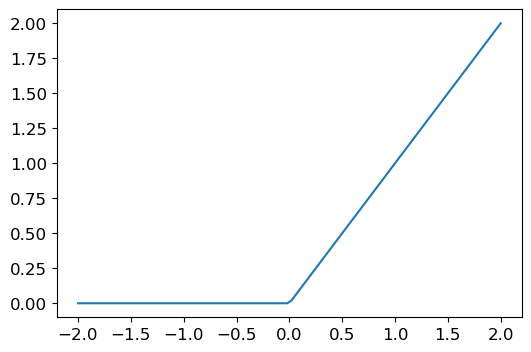

In [175]:
'''
so res.max(tensor(0)) is called a rectified linear unit
which you will always see refered to as ReLU
and in pytorch it already has this function - it's called F.relu()
and if we plot it you can see it's as you'd expect, 
it's 0 for all negative numbers and then it's y=x for positive numbers

jargon: rectified linear unit seems complicated but it's just this line of code: res = res.max(tensor(0.0))
and this happens a lot in deep learning 

so why do we do linear layer ReLU?
well, if we got rid of the middle relu and just went linear layer, linear layer
then you could rewrite that as a single linear layer when you multiply things and add and then multiply things and add
and you can just change the coefficients and make it into a single multiply and then add
so no matter how many linear layers we stack on top of each other, we can never make anything more effective than a simple linear model
but if you put a non-linearity between the linear layers
then actually you have the opposite

this is where something called universal approximation theorem holds 
which is that if the size of the weight and bias matrices are big enough
this can actually approximate any arbitrary function 
including the function of how do I recognize 3s from 7s or whatever  

so this is kind of amazing, this tiny thing (res = res.max(tensor(0.0))
is actually a universal function approximator as long as you have w1 b1 and w2 b2 have the right numbers
and we know how to make them the right numbers
we use SGD
could take a very long time, it could take a lot of memory
but the basic idea is that there is some solution to any computable problem 
and this is one of the biggest challenges a lot of beginners have to deep learning
is that there's nothing else to it
it's like, how do I make a neural net? that is the neural net
how do I do deep learning training with SGD
there's things to like make a train a bit faster
there's things to.. you need a few less parameters but everything from here is just performance tweaks
this is the key understanding of training a neural network
'''
plot_function(F.relu)

> J: There is an enormous amount of jargon in deep learning, including terms like **_rectified linear unit_.**  
> The vast vast majority of this jargon is no more complicated than can be implemented in a short line of code, as we saw in this example.  
> The reality is that for academics to get their papers published they need to make them sound as impressive and sophisticated as possible.  
> One of the ways that they do that is to introduce jargon.  
> Unfortunately, this has the result that the field ends up becoming far more intimidating and difficult to get into than it should be.  
> You do have to learn the jargon, because otherwise papers and tutorials are not going to mean much to you.  
> But that doesn't mean you have to find the jargon intimidating.  
> Just remember, when you come across a word or phrase that you haven't seen before,  
> it will almost certainly turn out to be referring to a very simple concept.  

**The basic idea is that by using more linear layers, we can have our model do more computation,  
and therefore model more complex functions.**  
**But there's no point just putting one linear layer directly after another one,**  
because when we multiply things together and then add them up multiple times,  
that could be replaced by multiplying different things together and adding them up just once!  
That is to say, **a series of any number of linear layers in a row can be replaced with a single linear layer with a different set of parameters.**  

**But if we put a nonlinear function between them, such as `max`, then this is no longer true.**  
**Now each linear layer is actually somewhat decoupled from the other ones, and can do its own useful work.**  
The `max` function is particularly interesting, because it operates as a simple `if` statement.  

> S: Mathematically, we say the composition of two linear functions is another linear function.  
> So, we can stack as many linear classifiers as we want on top of each other,  
> and without nonlinear functions between them, it will just be the same as one linear classifier.  

**Amazingly enough, it can be mathematically proven that this little function can solve any computable problem to an arbitrarily high level of accuracy,  
if you can find the right parameters for `w1` and `w2` and if you make these matrices big enough.**    
For any arbitrarily wiggly function, we can approximate it as a bunch of lines joined together;  
to make it closer to the wiggly function, we just have to use shorter lines.  
This is known as the ***universal approximation theorem***.  
The three lines of code that we have here are known as ***layers***.  
**The first and third are known as *linear layers*,  
and the second line of code is known variously as a *nonlinearity*, or *activation function*.**    

Just like in the previous section, we can replace this code with something a bit simpler, **by taking advantage of PyTorch:**  

In [176]:
'''
ok, we can simplify things a bit more
we already know that we can use nn.linear to replace the weight and bias
so let's do that for both 
and since we're simply taking the result of one function and passing it into the next (res to res)
and take the result of that function and pass it to the next and so forth and then return the end (end res)
this is called function composition
function composition is when you just take the result of one function, pass it to a new one
so every pretty much neural network is just doing function composition of linear layers
and these (res.max etc) are called activation functions or nonlinearities
so pytorch provides something to do function composition for us
and it's called nn.sequential 
so it's gonna do a linear layer, 
pass the result to a ReLu
you pass the result to a linear layer

see here I'm not using F.relu, I'm using nn.relu
this is identical, returns exactly the same thing
but this is a class rather than a function
'''
simple_net = nn.Sequential(
    nn.Linear(28*28,30),
    nn.ReLU(),
    nn.Linear(30,1)
)

**`nn.Sequential` creates a module that will call each of the listed layers or functions in turn.**  

**`nn.ReLU` is a PyTorch module** that does exactly the same thing as the **`F.relu` function.**  
Most functions that can appear in a model also have identical forms that are modules.  
Generally, it's just a case of replacing `F` with `nn` and changing the capitalization.  
When using `nn.Sequential`, PyTorch requires us to use the module version.  
Since modules are classes, we have to instantiate them, which is why you see `nn.ReLU()` in this example.  

**Because `nn.Sequential` is a module, we can get its parameters,**  
which will return a list of all the parameters of all the modules it contains.  
Let's try it out!  
As this is a deeper model, we'll use a lower learning rate and a few more epochs.  

In [177]:
'''
now that we have a neural net (simple_net) 
we can use the same learner we had before but this time we pass in the simple_net instead of linear one
everything else is the same and we can call fit just like before

and generally, as your models get deeper
so here we've gone from 1 layer to 2 (at simple_net, calculate only the parametrized layer (withotu relu))
you could say it's 3. I'm going to call it 2,  there's 2 trainable layers
so I've gone from 1 layer to 2 (started with linear1)
I've dropped my learning r ate from 1 to 0.1 because the deeper models (with more layers) all tend to be bumpier
less nicely behaved so often you need to use lower learning rates
'''
learn = Learner(dls, simple_net, opt_func=SGD,
                loss_func=mnist_loss, metrics=batch_accuracy)

In [178]:
#hide_output
learn.fit(40, 0.1)

epoch,train_loss,valid_loss,batch_accuracy,time
0,0.306178,0.399517,0.508832,00:00
1,0.142642,0.220382,0.817468,00:00
2,0.079635,0.112032,0.921001,00:00
3,0.052750,0.076199,0.943572,00:00
4,0.040225,0.059813,0.959274,00:00
5,0.033792,0.050623,0.963199,00:00
6,0.030072,0.044810,0.965653,00:00
7,0.027641,0.040804,0.966634,00:00
8,0.025880,0.037863,0.969578,00:00
9,0.024511,0.035601,0.970069,00:00


We're not showing the 40 lines of output here to save room;  
**the training process is recorded in `learn.recorder`,**  
with the table of output stored in the `values` attribute,  
so we can plot **the accuracy over training as:**

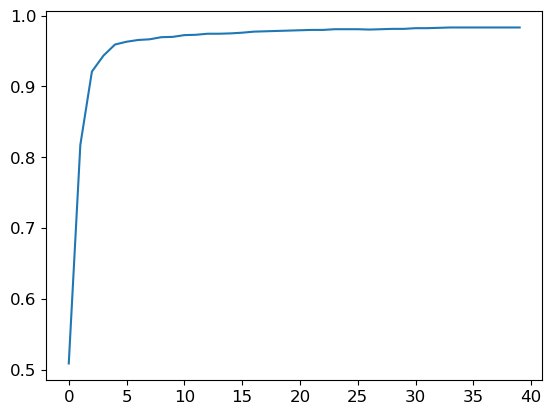

In [179]:
'''
and so we've trained for a while, and we can actually find out what that training looks like
by looking inside our learner and there's an attribute we create for you called recorder 
and that's going to record everything that appears in this table (learn.fit results)
bascally, these 3 things: training loss, validation loss and the batch accuracy or any metrics 
so recorded our values, contains that table of results
and so item number 2 of each row will be the accuracy  
so the capital L class, which I'm using here as a nice little method called .itemgot
that will get the second item for every row and then I can plot that to see how the training went
'''
plt.plot(L(learn.recorder.values).itemgot(2));  # plot accuracy

**And we can view the final accuracy:**

In [180]:
'''
and I can get the final accuracy by grabbing the last row of the table and index 2 (0,1,2) - 98.3%

1. we now have a function that can solve any problem to any level of accuracy if we can find the right parameters
2. and we have a way to find the best or at least the very good set of parameters for any function

'''
learn.recorder.values[-1][2]

0.983316957950592

In [181]:
'''
if you want to grab the model
you can look inside the model to see the actual model that we just trained and you can see it's got the 3 things in it:
the linear
the relu
the linear

I put that into a variable to make it easier to work with
'''
#learn.model
m = learn.model
m

Sequential(
  (0): Linear(in_features=784, out_features=30, bias=True)
  (1): ReLU()
  (2): Linear(in_features=30, out_features=1, bias=True)
)

In [190]:
'''
you can grab one layer by indexing
you can look at the parameters, this will give something called a generator
'''
m[0].parameters()

<generator object Module.parameters at 0x7eff384082e0>

In [196]:
'''
it's something that will give me a list of the parameters when I ask for them 
with w,b to destructure them
'''
w,b = m[0].parameters()

In [188]:
'''
so the weight is 30 by 784 because that's what I ask for
so one of the things to note here is that to create a neural net (so something that's more than one layer)
I actually have 30 outputs, not just 1, right? [simple_net = nn.seq (nn.Linear(xx,30))]
so I'm kind of generating lots of features
so it's kind of like 30 different linear models here
and then I combined those 30 back into 1 (with the 2nd linear)
'''
w.shape, b.shape

(torch.Size([30, 784]), torch.Size([30]))

In [192]:
'''
so you could look at one of those by having a look at here
so there's the numbers in the first row
'''
w[0]

tensor([-3.0100e-02,  1.9052e-02,  2.9477e-02, -3.4425e-02,  6.4140e-03, -1.0457e-02,  2.1451e-02,  1.5624e-02,  1.7567e-02,  3.0049e-02,  3.1262e-02, -2.0492e-02,  2.5520e-02, -8.0380e-03,
         3.3780e-02, -2.6922e-02, -7.4052e-04, -2.2814e-02, -3.5086e-02, -3.5390e-02, -2.3421e-02, -7.2024e-03,  2.3453e-02, -3.5592e-02,  1.7864e-02,  2.1052e-02, -1.1565e-02,  2.7005e-03,
        -1.2803e-02, -8.2192e-03, -1.4972e-02,  2.1738e-02, -2.0701e-02,  2.6458e-02,  1.2580e-02,  2.9975e-02,  1.5550e-03,  2.6571e-02, -2.6625e-02, -5.1075e-03, -7.5398e-03, -1.8958e-02,
        -2.4748e-02,  3.2386e-02,  3.0870e-03,  2.0842e-02,  7.0747e-03,  1.8930e-02, -3.0142e-02, -1.5400e-03,  1.8391e-02,  2.7783e-04, -1.3994e-02,  2.0310e-03, -2.8694e-02,  1.3494e-02,
         6.0580e-03, -2.8467e-02,  2.0373e-02, -3.0352e-02,  1.8536e-02, -2.3559e-02, -3.3395e-02,  5.8225e-03, -5.0159e-03,  2.8023e-02, -1.6682e-02,  3.3784e-02,  8.7398e-03,  4.3036e-03,
         6.7939e-03,  9.9093e-03,  1.8955e-02,  3.

In [193]:
'''
we could reshape that into the original shape of the images
'''
w[0].view(28,28)

tensor([[-3.0100e-02,  1.9052e-02,  2.9477e-02, -3.4425e-02,  6.4140e-03, -1.0457e-02,  2.1451e-02,  1.5624e-02,  1.7567e-02,  3.0049e-02,  3.1262e-02, -2.0492e-02,  2.5520e-02, -8.0380e-03,
          3.3780e-02, -2.6922e-02, -7.4052e-04, -2.2814e-02, -3.5086e-02, -3.5390e-02, -2.3421e-02, -7.2024e-03,  2.3453e-02, -3.5592e-02,  1.7864e-02,  2.1052e-02, -1.1565e-02,  2.7005e-03],
        [-1.2803e-02, -8.2192e-03, -1.4972e-02,  2.1738e-02, -2.0701e-02,  2.6458e-02,  1.2580e-02,  2.9975e-02,  1.5550e-03,  2.6571e-02, -2.6625e-02, -5.1075e-03, -7.5398e-03, -1.8958e-02,
         -2.4748e-02,  3.2386e-02,  3.0870e-03,  2.0842e-02,  7.0747e-03,  1.8930e-02, -3.0142e-02, -1.5400e-03,  1.8391e-02,  2.7783e-04, -1.3994e-02,  2.0310e-03, -2.8694e-02,  1.3494e-02],
        [ 6.0580e-03, -2.8467e-02,  2.0373e-02, -3.0352e-02,  1.8536e-02, -2.3559e-02, -3.3395e-02,  5.8225e-03, -5.0159e-03,  2.8023e-02, -1.6682e-02,  3.3784e-02,  8.7398e-03,  4.3036e-03,
          6.7939e-03,  9.9093e-03,  1.8955e

<Axes: >

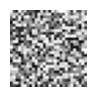

In [201]:
'''
and we could even have a look and there it is
so you can see this is something which is kind of learning to find things at the top and the bottom and the middle (me: pointing to the image)
and we can look at the 2nd one w[1] - no idea what is that showing
I probably got far more than I need, which is why they're not that obvious

but you can see, here's another thing that's looking pretty similar w[4]
king of looking for this little bit in the middle, 
so yeah, this is the basic idea, to understand the features that are not the 1st layer but later layers you have to be a bit more sophisticated
but you can see the first layer ones , you can just plot them
'''
show_image(w[0].view(28,28))

At this point we have something that is rather **magical:**    

1. **A function that can solve any problem to any level of accuracy (the neural network) given the correct set of parameters**    
1. **A way to find the best set of parameters for any function (stochastic gradient descent)**  

This is why deep learning can do things which seem rather magical, such fantastic things.  
Believing that this combination of simple techniques can really solve any problem is one of the biggest steps that we find many students have to take.  
It seems too good to be true — surely things should be more difficult and complicated than this?  
Our recommendation: try it out!  
We just tried it on the MNIST dataset and you have seen the results.  
And since we are doing everything from scratch ourselves (except for calculating the gradients) you know that there is no special magic hiding behind the scenes. 

### Going Deeper

**There is no need to stop at just two linear layers.**  
**We can add as many as we want, as long as we add a nonlinearity between each pair of linear layers.**  
As you will learn, however, the deeper the model gets, the harder it is to optimize the parameters in practice.  
Later in this book you will learn about some simple but brilliantly effective techniques for training deeper models.

We already know that a single nonlinearity with two linear layers is enough to approximate any function.  
**So why would we use deeper models?**  
**The reason is performance.**  
**<u>With a deeper model (that is, one with more layers) we do not need to use as many parameters;</u>**  
it turns out that we can use smaller matrices with more layers, and get better results than we would get with larger matrices, and few layers.  

**That means that we can train the model more quickly, and it will take up less memory.**  
In the 1990s researchers were so focused on the universal approximation theorem that very few were experimenting with more than one nonlinearity.  
This theoretical but not practical foundation held back the field for years.  
Some researchers, however, did experiment with deep models, and eventually were able to show that these models could perform much better in practice.  
**Eventually, theoretical results were developed which showed why this happens.**  
Today, it is extremely unusual to find anybody using a neural network with just one nonlinearity.

**Here is what happens when we train an 18-layer model using the same approach we saw in <<chapter_intro>>:**

In [184]:
'''
ok, so just to compare we could use the full fastai toolkit   
grab out data loaders by using data loaders from folder as we've done before
and create a cnn_learner and a resnet and fit it for a single epoch and whoa, 99.7%

we did 40 epochs and got 98.3%, as I said, 
using all the tricks you can really speed things up and make things a lot better
so by the end of this course or at least both parts of this course
you'll be able to, from scratch, get this 99.7% in a single epoch


'''
dls = ImageDataLoaders.from_folder(path)
learn = vision_learner(dls, resnet18, pretrained=False,
                    loss_func=F.cross_entropy, metrics=accuracy)
learn.fit_one_cycle(1, 0.1)

/home/ltr01/mambaforge/envs/fastai23/lib/python3.11/site-packages/fastai/data/transforms.py:225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(col):
/home/ltr01/mambaforge/envs/fastai23/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/ltr01/mambaforge/envs/fastai23/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


epoch,train_loss,valid_loss,accuracy,time
0,0.075454,0.021230,0.995584,00:19


/home/ltr01/mambaforge/envs/fastai23/lib/python3.11/site-packages/torch/nn/modules/conv.py:459: UserWarning: Applied workaround for CuDNN issue, install nvrtc.so (Triggered internally at /opt/conda/conda-bld/pytorch_1682343995622/work/aten/src/ATen/native/cudnn/Conv_v8.cpp:80.)
  return F.conv2d(input, weight, bias, self.stride,


**Nearly 100% accuracy!**  
**That's a big difference compared to our simple neural net.**  
But as you'll learn in the remainder of this book,  
**there are just a few little tricks you need to use to get such great results from scratch yourself.**  
You already know the key foundational pieces.  
(Of course, even once you know all the tricks,  
**you'll nearly always want to work with the pre-built classes provided by PyTorch and fastai,  
because they save you having to think about all the little details yourself.)**

## Jargon Recap

Congratulations: you now know how to create and train a deep neural network from scratch!  
We've gone through quite a few steps to get to this point, **but you might be surprised at how simple it really is.**  

Now that we are at this point, it is a good opportunity to define, and review, some jargon and key concepts.  

A neural network contains a lot of numbers, but they are only of two types:  
numbers that are calculated, and the parameters that these numbers are calculated from.  
This gives us the two most important pieces of jargon to learn:

- **Activations:: Numbers that are calculated (both by linear and nonlinear layers)**
- **Parameters:: Numbers that are randomly initialized, and optimized (that is, the numbers that define the model)**

We will often talk in this book about activations and parameters.  
Remember that they have very specific meanings.  
They are numbers.  
They are not abstract concepts, but they are actual specific numbers that are in your model.  
**Part of becoming a good deep learning practitioner is getting used to the idea of actually looking at your activations and parameters,**  
and plotting them and testing whether they are behaving correctly.

**Our activations and parameters are all contained in *tensors*.**  
These are simply regularly shaped arrays—for example, a matrix.  
Matrices have rows and columns; we call these the *axes* or *dimensions*.  
**The number of dimensions of a tensor is its *rank*.**  
There are some special tensors:

- Rank zero: scalar
- Rank one: vector
- Rank two: matrix

**A neural network contains a number of layers.  
Each layer is either *linear* or *nonlinear*.  
We generally alternate between these two kinds of layers in a neural network.**  
Sometimes people refer to both a linear layer and its subsequent nonlinearity together as a single layer.  
Yes, this is confusing.  
**Sometimes a nonlinearity is referred to as an *activation function*.**

<<dljargon1>> summarizes the key concepts related to SGD.

```asciidoc
[[dljargon1]]
.Deep learning vocabulary
[options="header"]
|=====
|Term | Meaning
|ReLU | Function that returns 0 for negative numbers and doesn't change positive numbers.
|Mini-batch | A small group of inputs and labels gathered together in two arrays. A gradient descent step is updated on this batch (rather than a whole epoch).
|Forward pass | Applying the model to some input and computing the predictions.
|Loss | A value that represents how well (or badly) our model is doing.
|Gradient | The derivative of the loss with respect to some parameter of the model.
|Backward pass | Computing the gradients of the loss with respect to all model parameters.
|Gradient descent | Taking a step in the directions opposite to the gradients to make the model parameters a little bit better.
|Learning rate | The size of the step we take when applying SGD to update the parameters of the model.
|=====
```

In [ ]:
'''
relu: function that returns 0 for negatives
mini-batch: a few inputs and labels, which optionally are randomnly selected 
forward pass: is the bit where we calculate the predictions
loss: the function that we're going to take the derivative of 
gradient: the derivative of the loss with respect to each parameter
backward pass: is when we calculate those gradients
gradient descent: full thing of taking a step in the direction opposite to the gradients after calculating the loss
learning rate: the size of the step that we take

other things to know: perhaps the 2 most important pieces of jargon are:
    parameters = the numbers that we're learning 
    activations = the numbers that we're calculating, so every relu that's calculated, every matrix multiplication element that's calculated
    
so activations and parameters are all of the numbers that are in a neural network
so be careful when I say from here on in these lessons activations or parameters you make sure you know what those mean
because that's the entire set of numbers that exist inside a neural network 
so activations are calculated, parameters are learned

we're doing this stuff with tensors, which are regularly shapped arrays
rank zero we call scalar, rank 1 vector, rank 2 matrix 
rank 5 tensors are very common in deep learning 

non linearity to choose: relu, leaky relu
some are taking longer and are more accurate, some are faster and a bit less accurate


'''

> note: _Choose Your Own Adventure_ Reminder:  
> Did you choose to skip over chapters 2 & 3, in your excitement to peek under the hood?  
> **Well, here's your reminder to head back to chapter 2 now, because you'll be needing to know that stuff very soon!**  

## Questionnaire

1. How is a grayscale image represented on a computer? How about a color image?
1. How are the files and folders in the `MNIST_SAMPLE` dataset structured? Why?
1. Explain how the "pixel similarity" approach to classifying digits works.
1. What is a list comprehension? Create one now that selects odd numbers from a list and doubles them.
1. What is a "rank-3 tensor"?
1. What is the difference between tensor rank and shape? How do you get the rank from the shape?
1. What are RMSE and L1 norm?
1. How can you apply a calculation on thousands of numbers at once, many thousands of times faster than a Python loop?
1. Create a 3×3 tensor or array containing the numbers from 1 to 9. Double it. Select the bottom-right four numbers.
1. What is broadcasting?
1. Are metrics generally calculated using the training set, or the validation set? Why?
1. What is SGD?
1. Why does SGD use mini-batches?
1. What are the seven steps in SGD for machine learning?
1. How do we initialize the weights in a model?
1. What is "loss"?
1. Why can't we always use a high learning rate?
1. What is a "gradient"?
1. Do you need to know how to calculate gradients yourself?
1. Why can't we use accuracy as a loss function?
1. Draw the sigmoid function. What is special about its shape?
1. What is the difference between a loss function and a metric?
1. What is the function to calculate new weights using a learning rate?
1. What does the `DataLoader` class do?
1. Write pseudocode showing the basic steps taken in each epoch for SGD.
1. Create a function that, if passed two arguments `[1,2,3,4]` and `'abcd'`, returns `[(1, 'a'), (2, 'b'), (3, 'c'), (4, 'd')]`. What is special about that output data structure?
1. What does `view` do in PyTorch?
1. What are the "bias" parameters in a neural network? Why do we need them?
1. What does the `@` operator do in Python?
1. What does the `backward` method do?
1. Why do we have to zero the gradients?
1. What information do we have to pass to `Learner`?
1. Show Python or pseudocode for the basic steps of a training loop.
1. What is "ReLU"? Draw a plot of it for values from `-2` to `+2`.
1. What is an "activation function"?
1. What's the difference between `F.relu` and `nn.ReLU`?
1. The universal approximation theorem shows that any function can be approximated as closely as needed using just one nonlinearity.  
   So why do we normally use more?

### Further Research

1. Create your own implementation of `Learner` from scratch, based on the training loop shown in this chapter.
1. Complete all the steps in this chapter using the full MNIST datasets (that is, for all digits, not just 3s and 7s).  
   This is a significant project and will take you quite a bit of time to complete!  
   You'll need to do some of your own research to figure out how to overcome some obstacles you'll meet on the way.  

In [ ]:
'''
2020 1h:10min 
now you know how to create and train a neural net
let's cycle back and look deeper at some applications
so we're going to try to interpolate in 
from one end we've done they're kind of from scratch version
at the other end we've done the kind of 4 lines of code version
and we'll gradually nibble at each end until we find ourselved in the middle and we've touched on all of it
so let's go back up to the kind of the 4 lines of code version and delve a little deeper
this is chapter 5


'''